In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ------------------------
# 1. Find global min and max elasticity across all files
# ------------------------
global_min, global_max = float('inf'), float('-inf')
# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
plot_dir = os.path.join(data_dir, "pics_bayes")
os.makedirs(plot_dir, exist_ok=True)

# Basin-station mapping
summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="Sheet1")

# List of 6 result files
files = [
    "ElasticityBM_AnnualSum.xlsx",
    "ElasticityBM_AnnualSum_NoStorage.xlsx",
    "ElasticityBM_Monsoon.xlsx",
    "ElasticityBM_MonsoonSum_NoStorage.xlsx",
    "ElasticityBM_LongTermMean.xlsx",
    "ElasticityBM_LongTermMean_NoStorage.xlsx"
]

for f in files:
    elasticity_df = pd.read_excel(os.path.join(trace_dir, f), sheet_name="Sheet1")
    # update global min and max
    file_min = elasticity_df['Elasticity'].min()
    file_max = elasticity_df['Elasticity'].max()
    if file_min < global_min:
        global_min = file_min
    if file_max > global_max:
        global_max = file_max

print(f"Global elasticity range: {global_min:.3f} to {global_max:.3f}")


Global elasticity range: 0.004 to 1.117


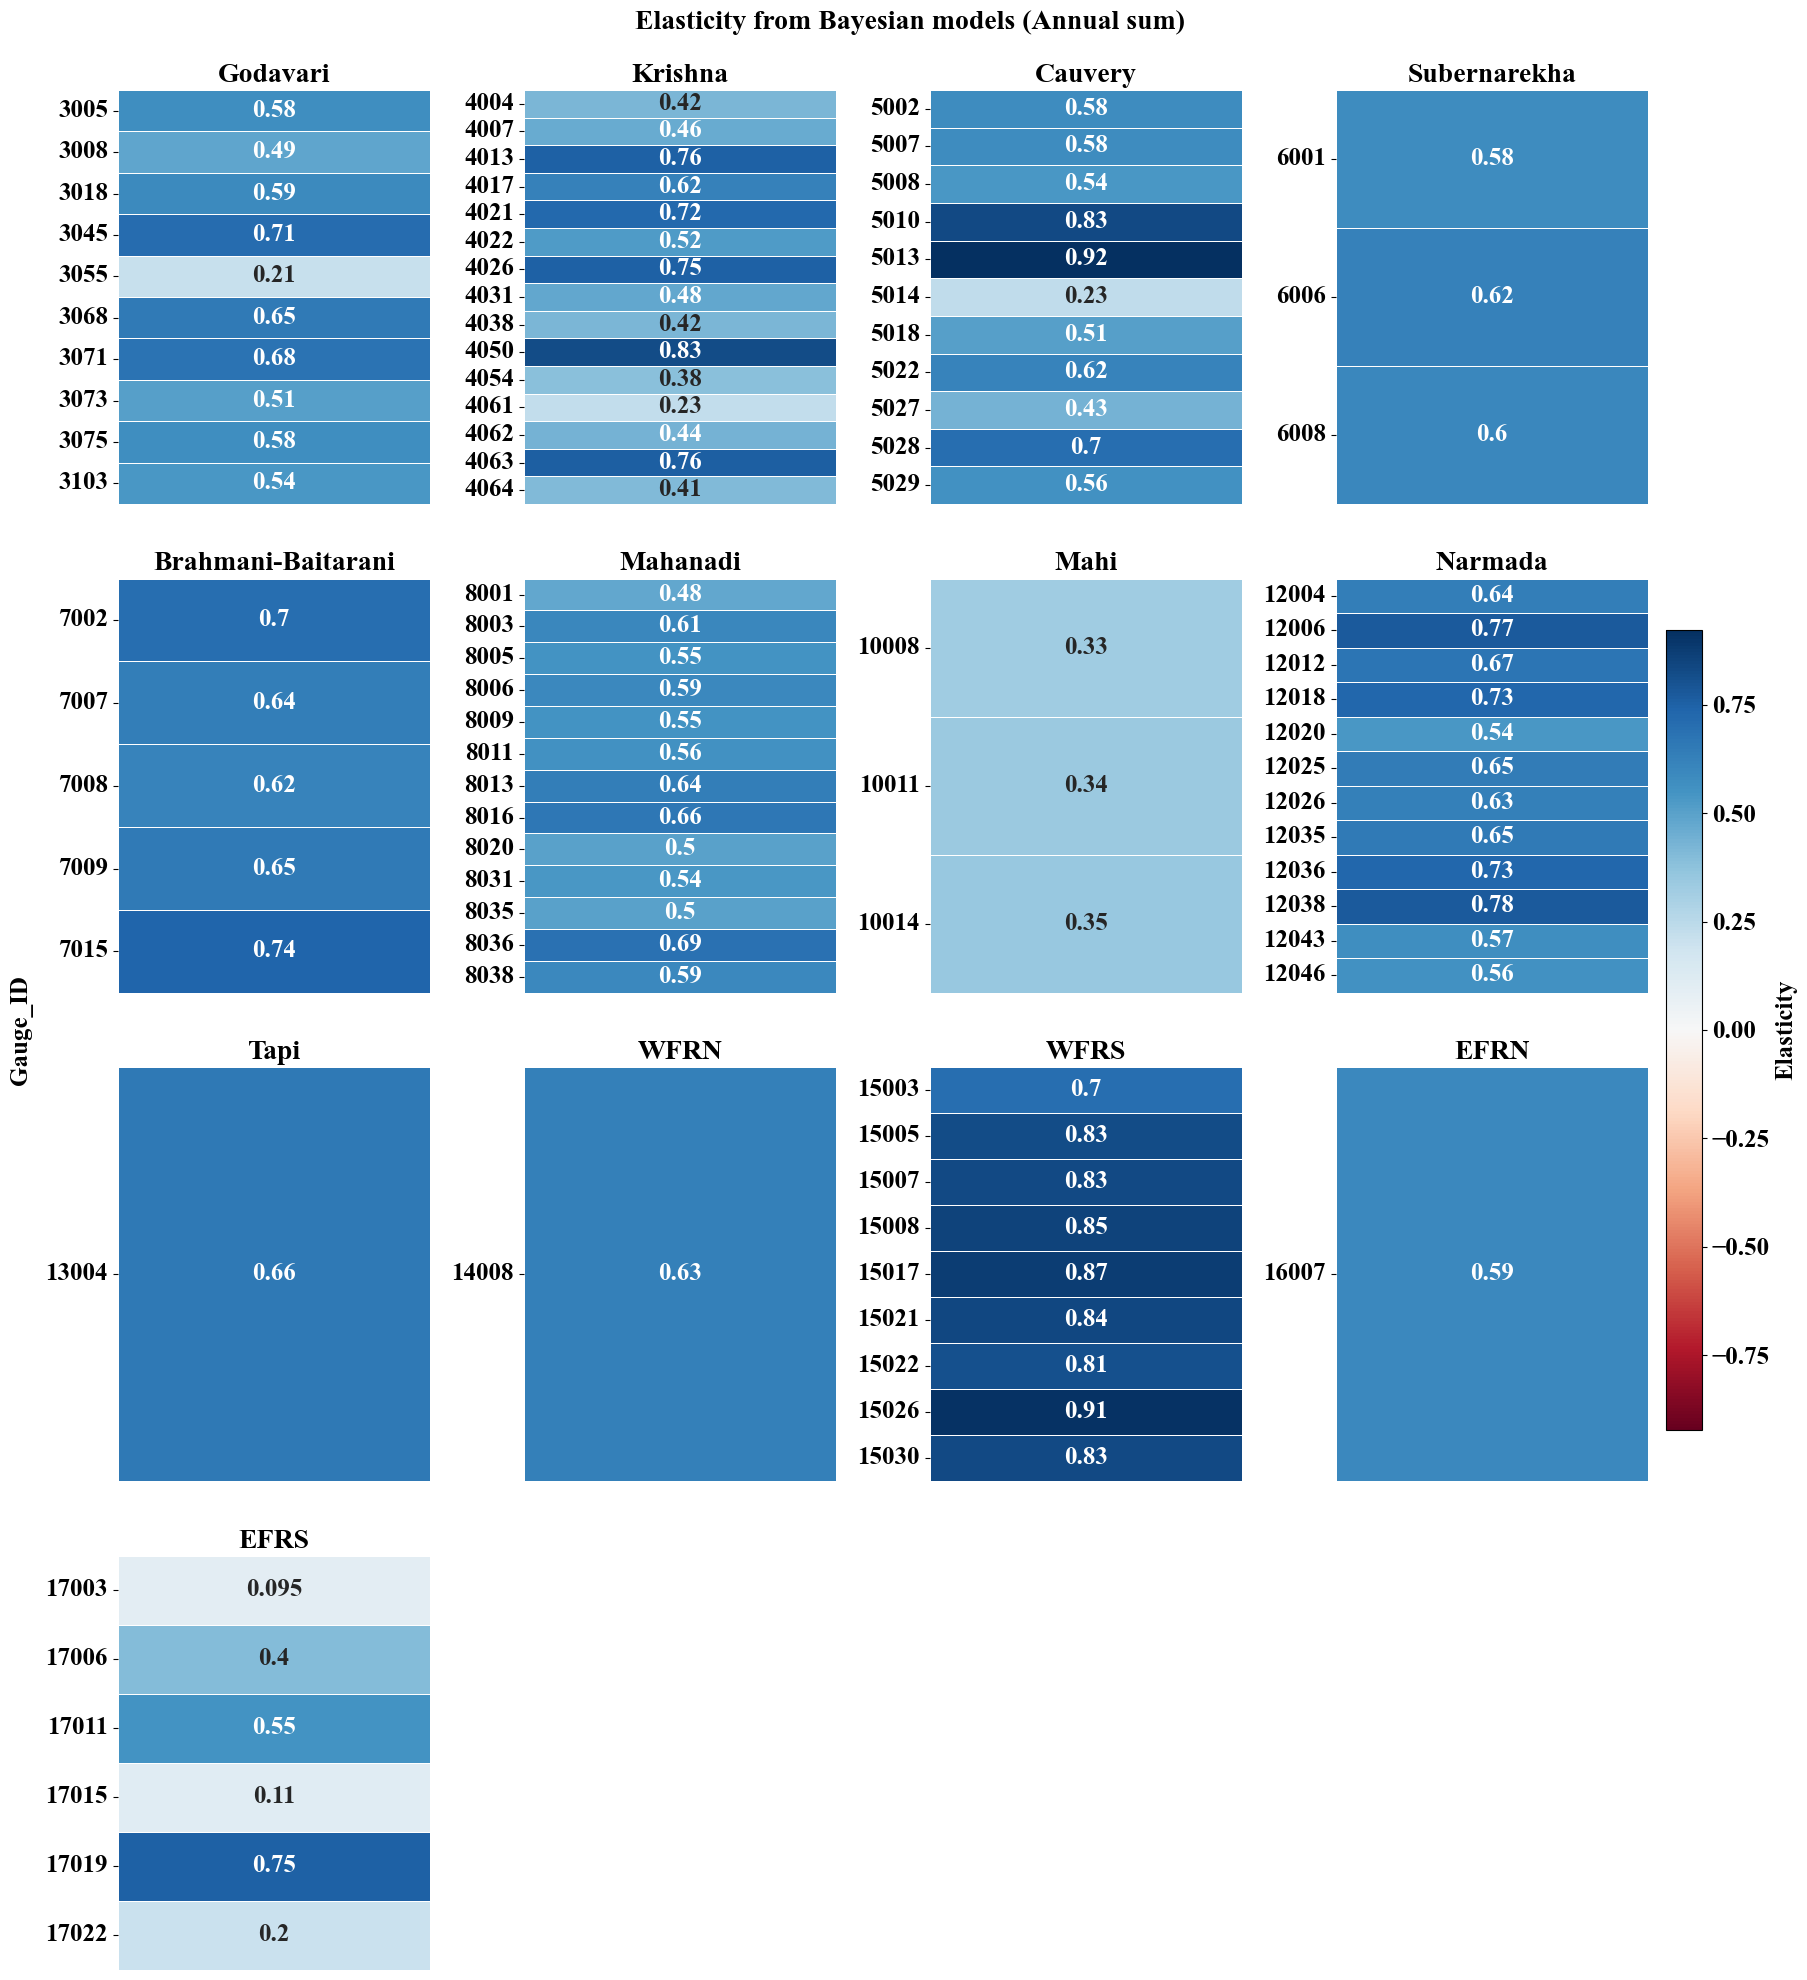

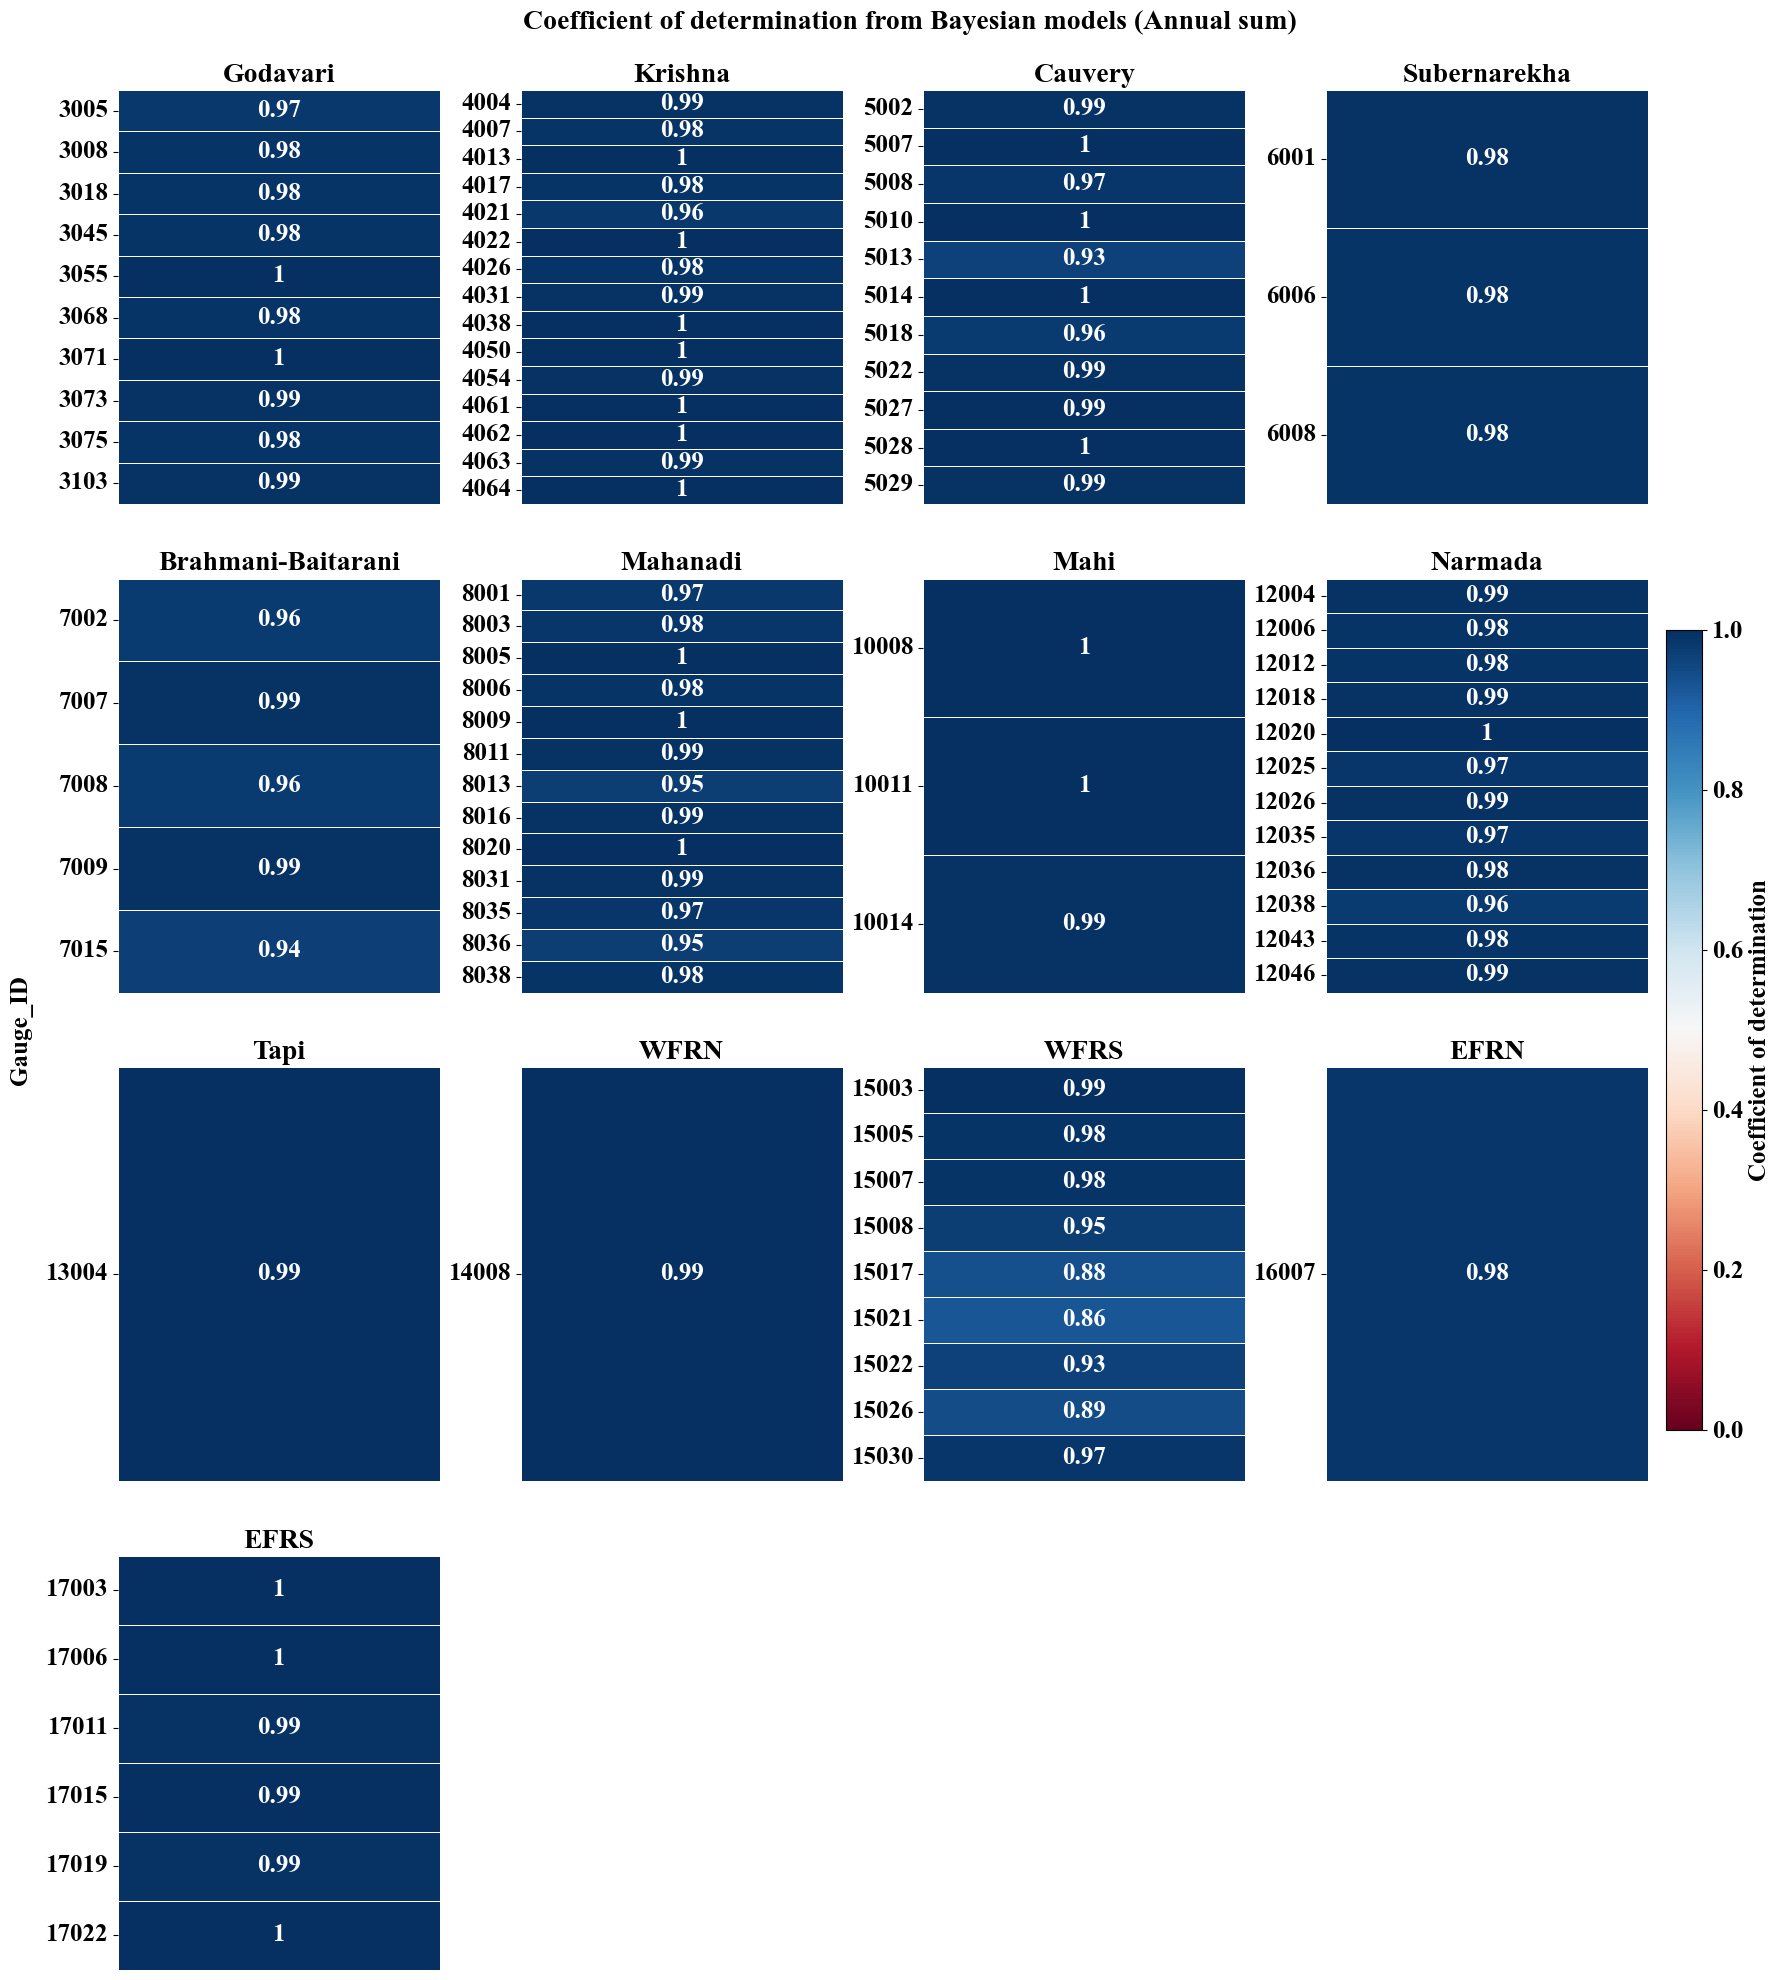

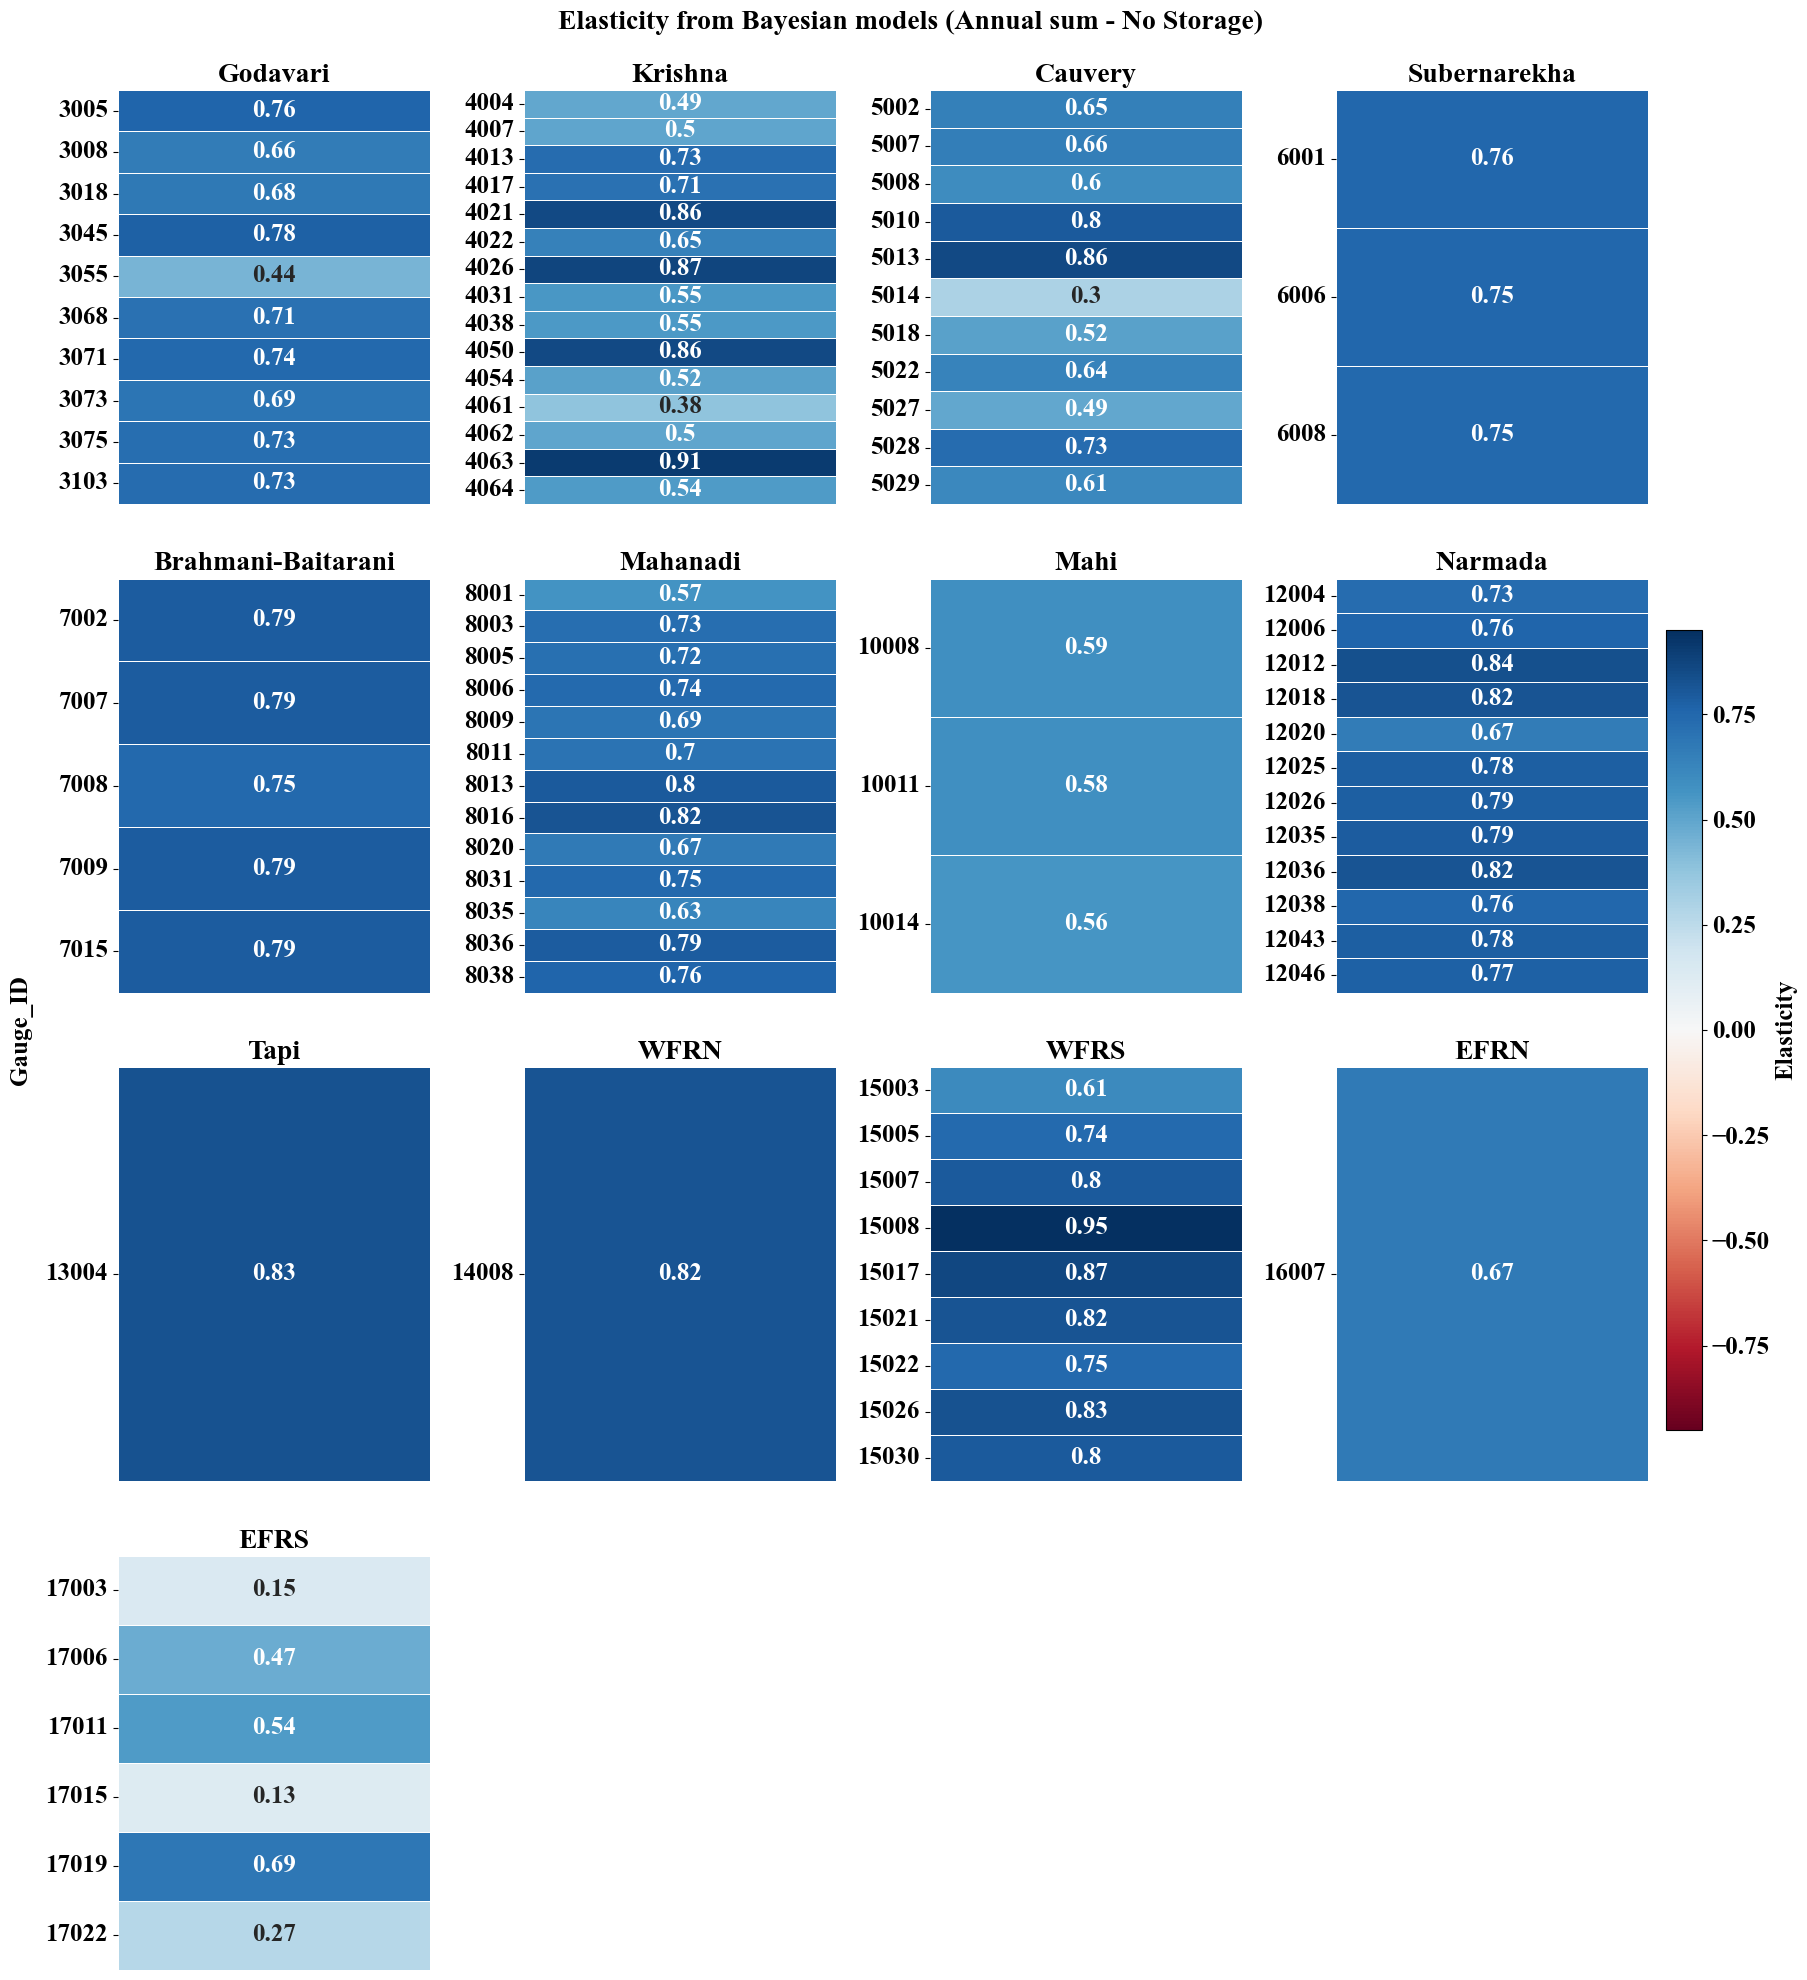

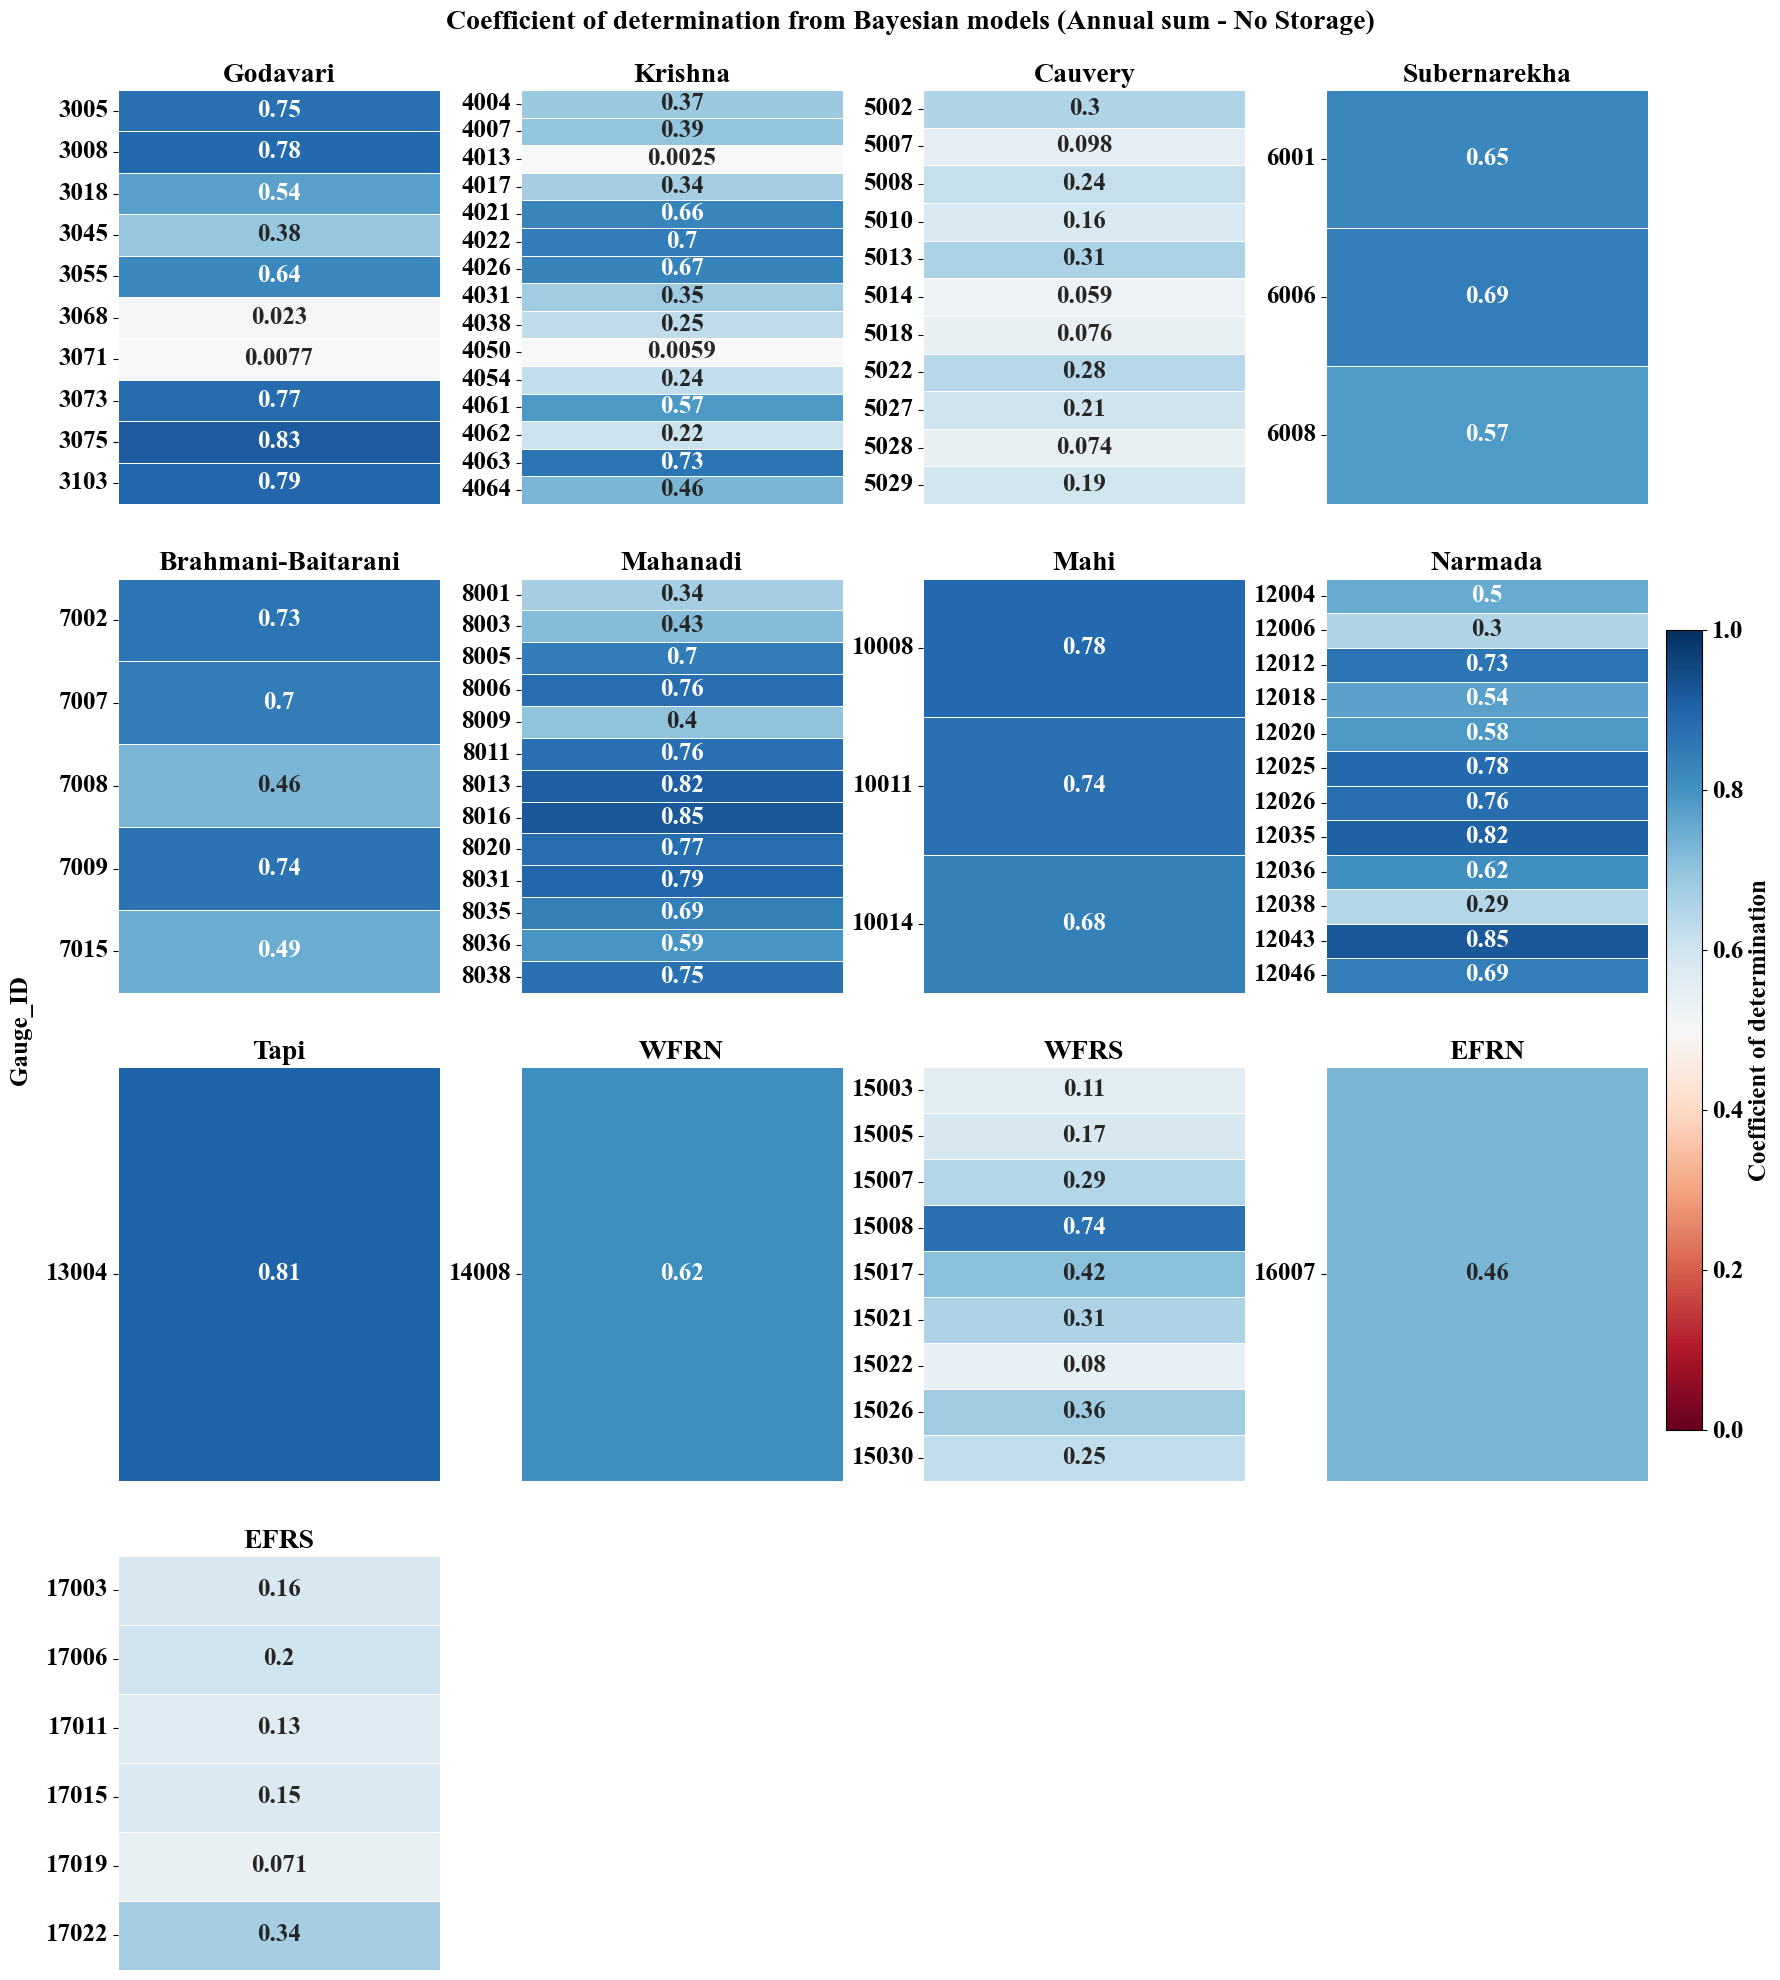

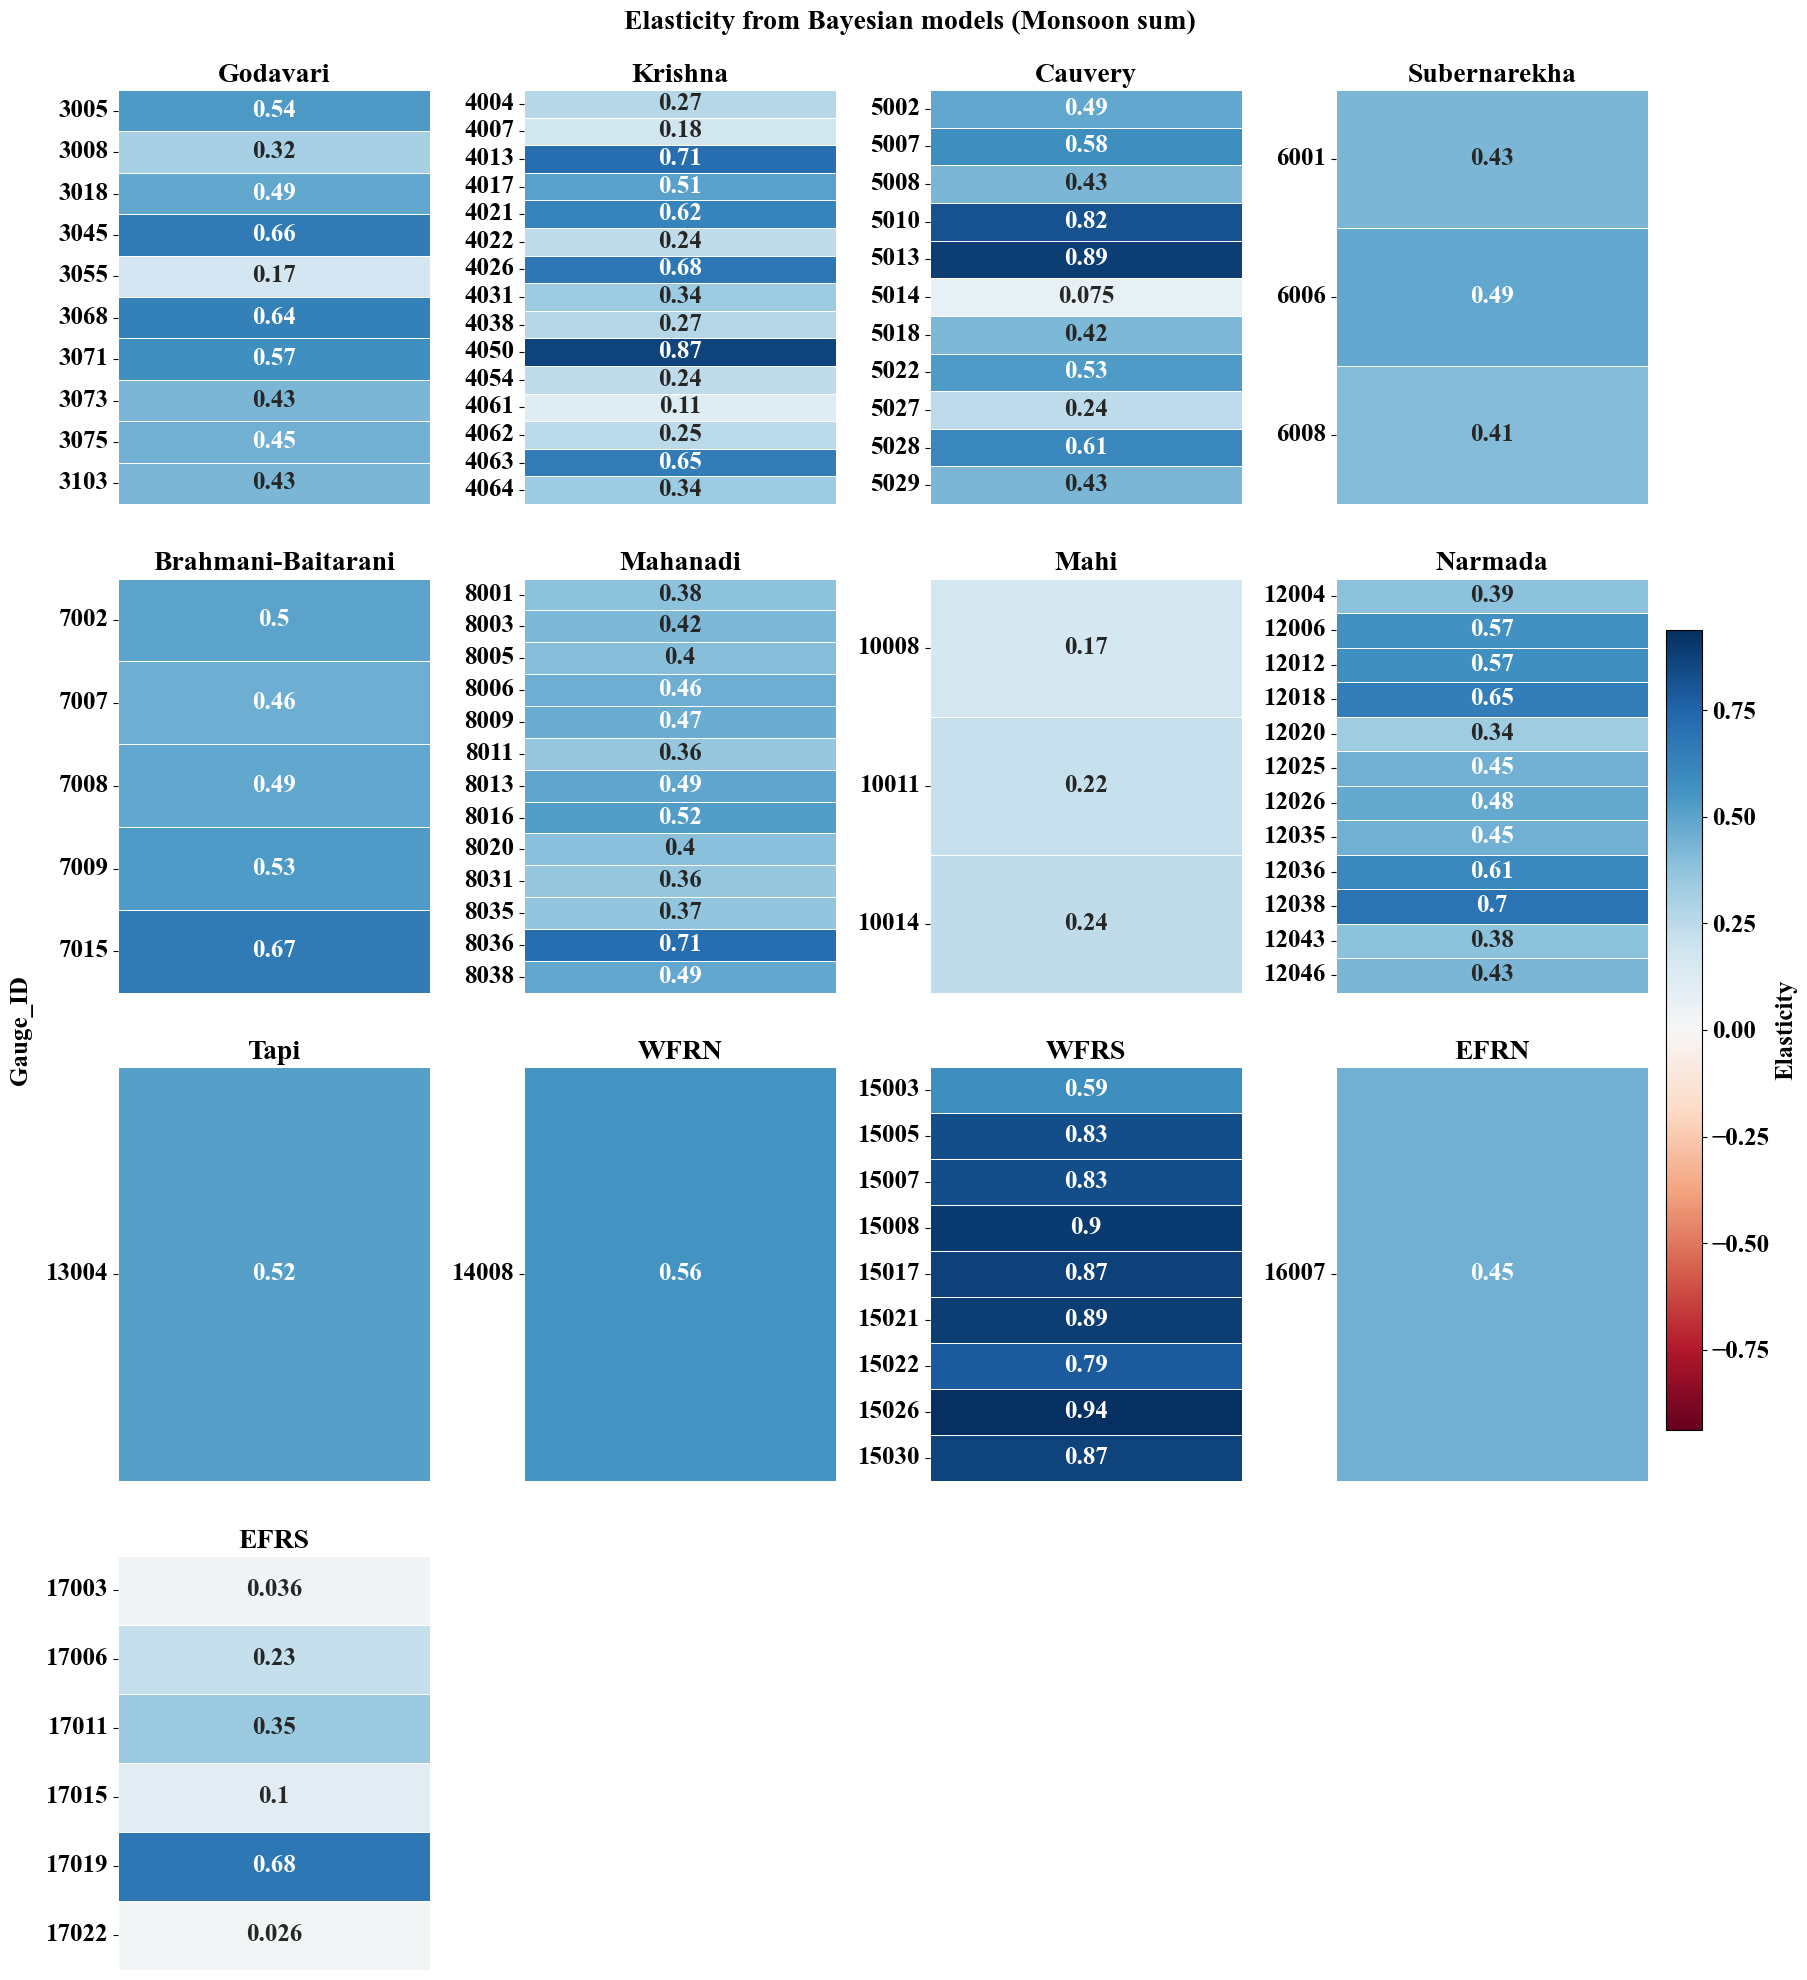

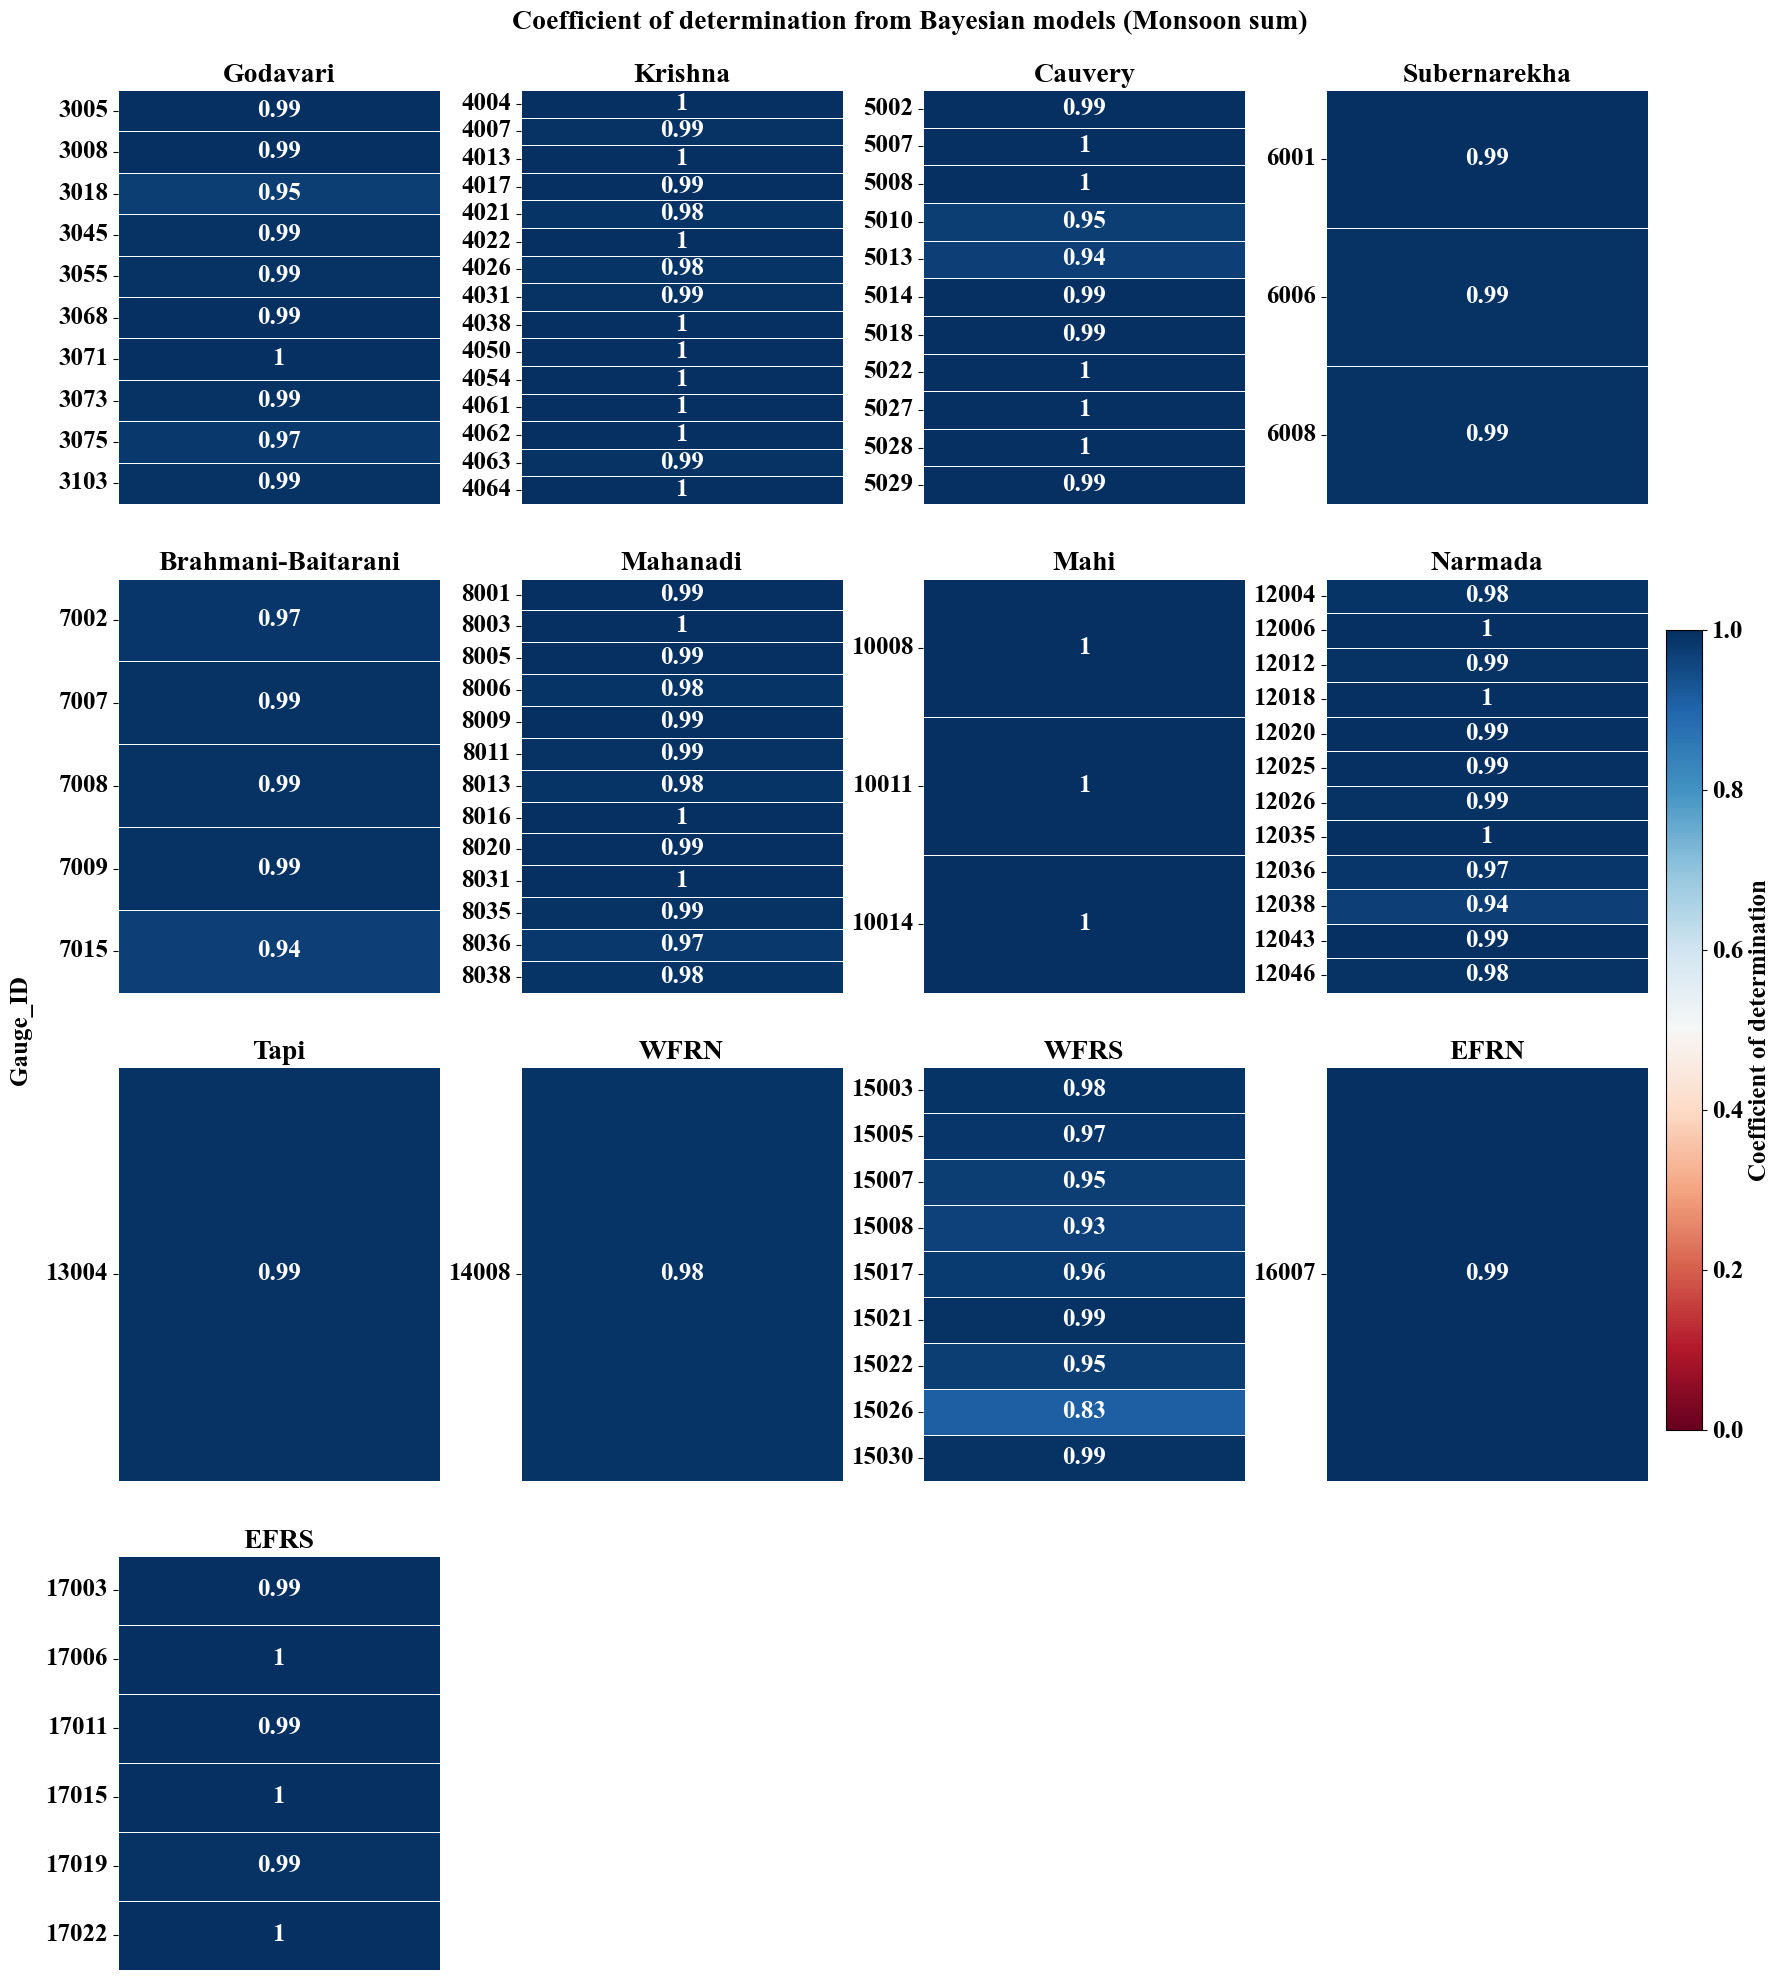

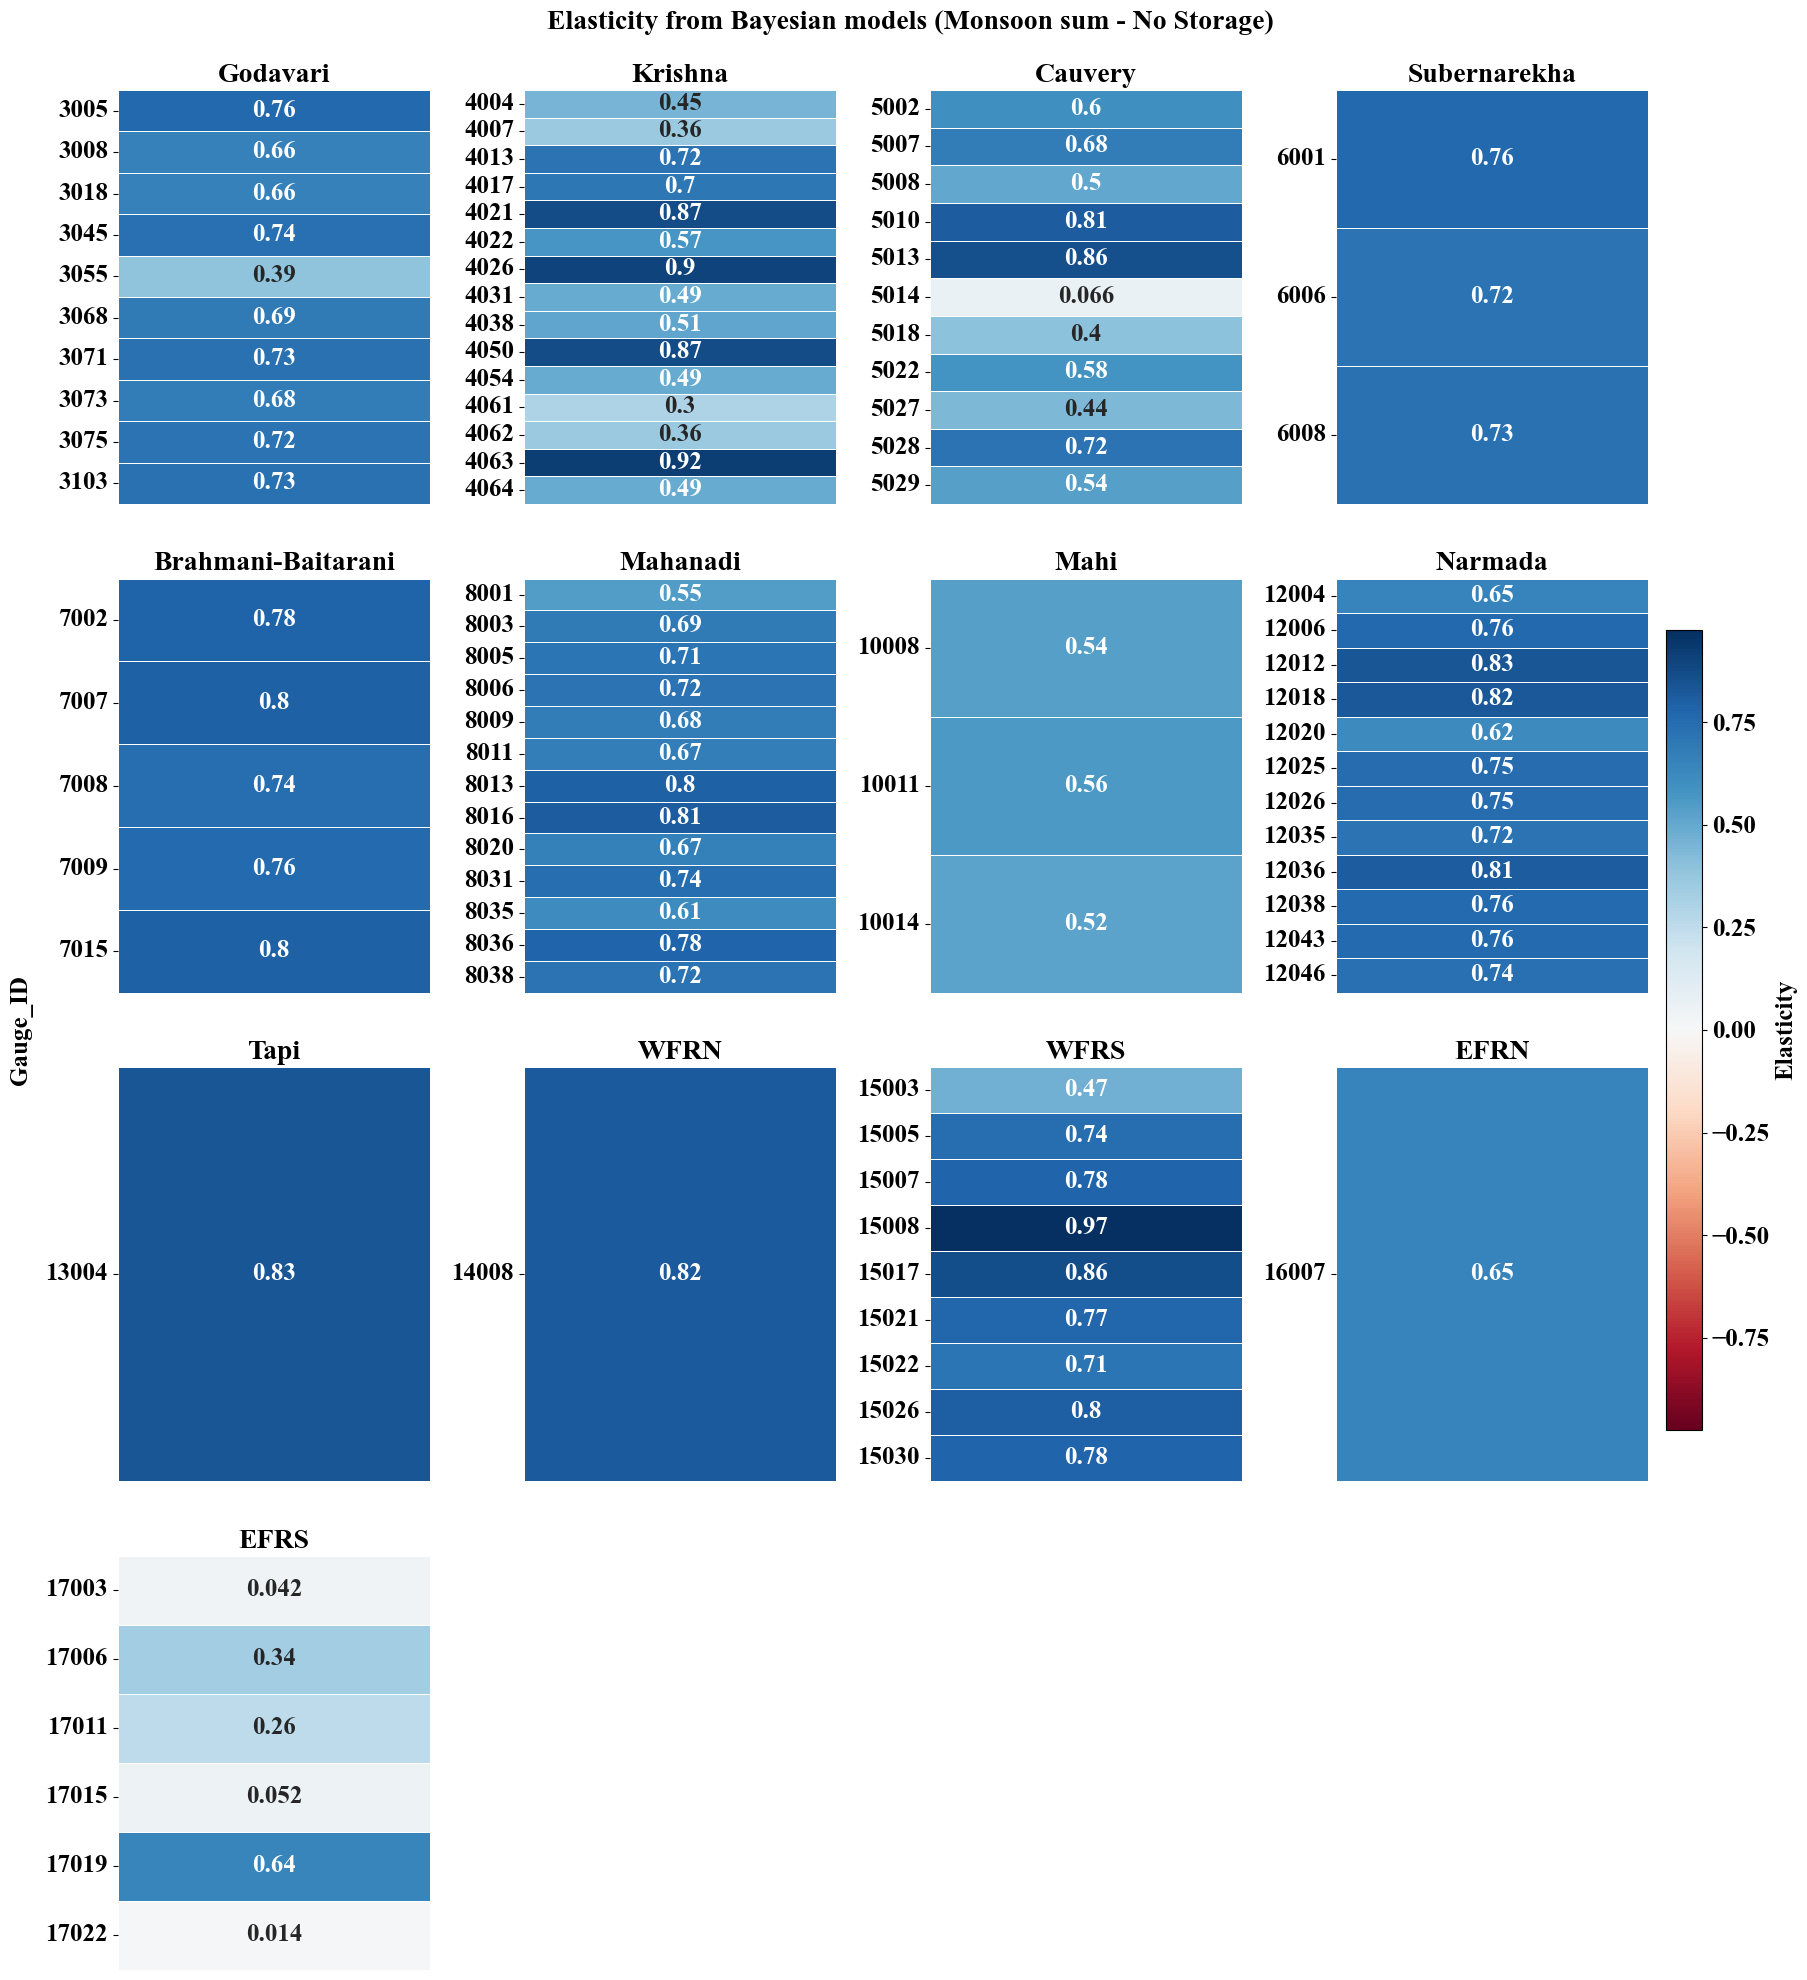

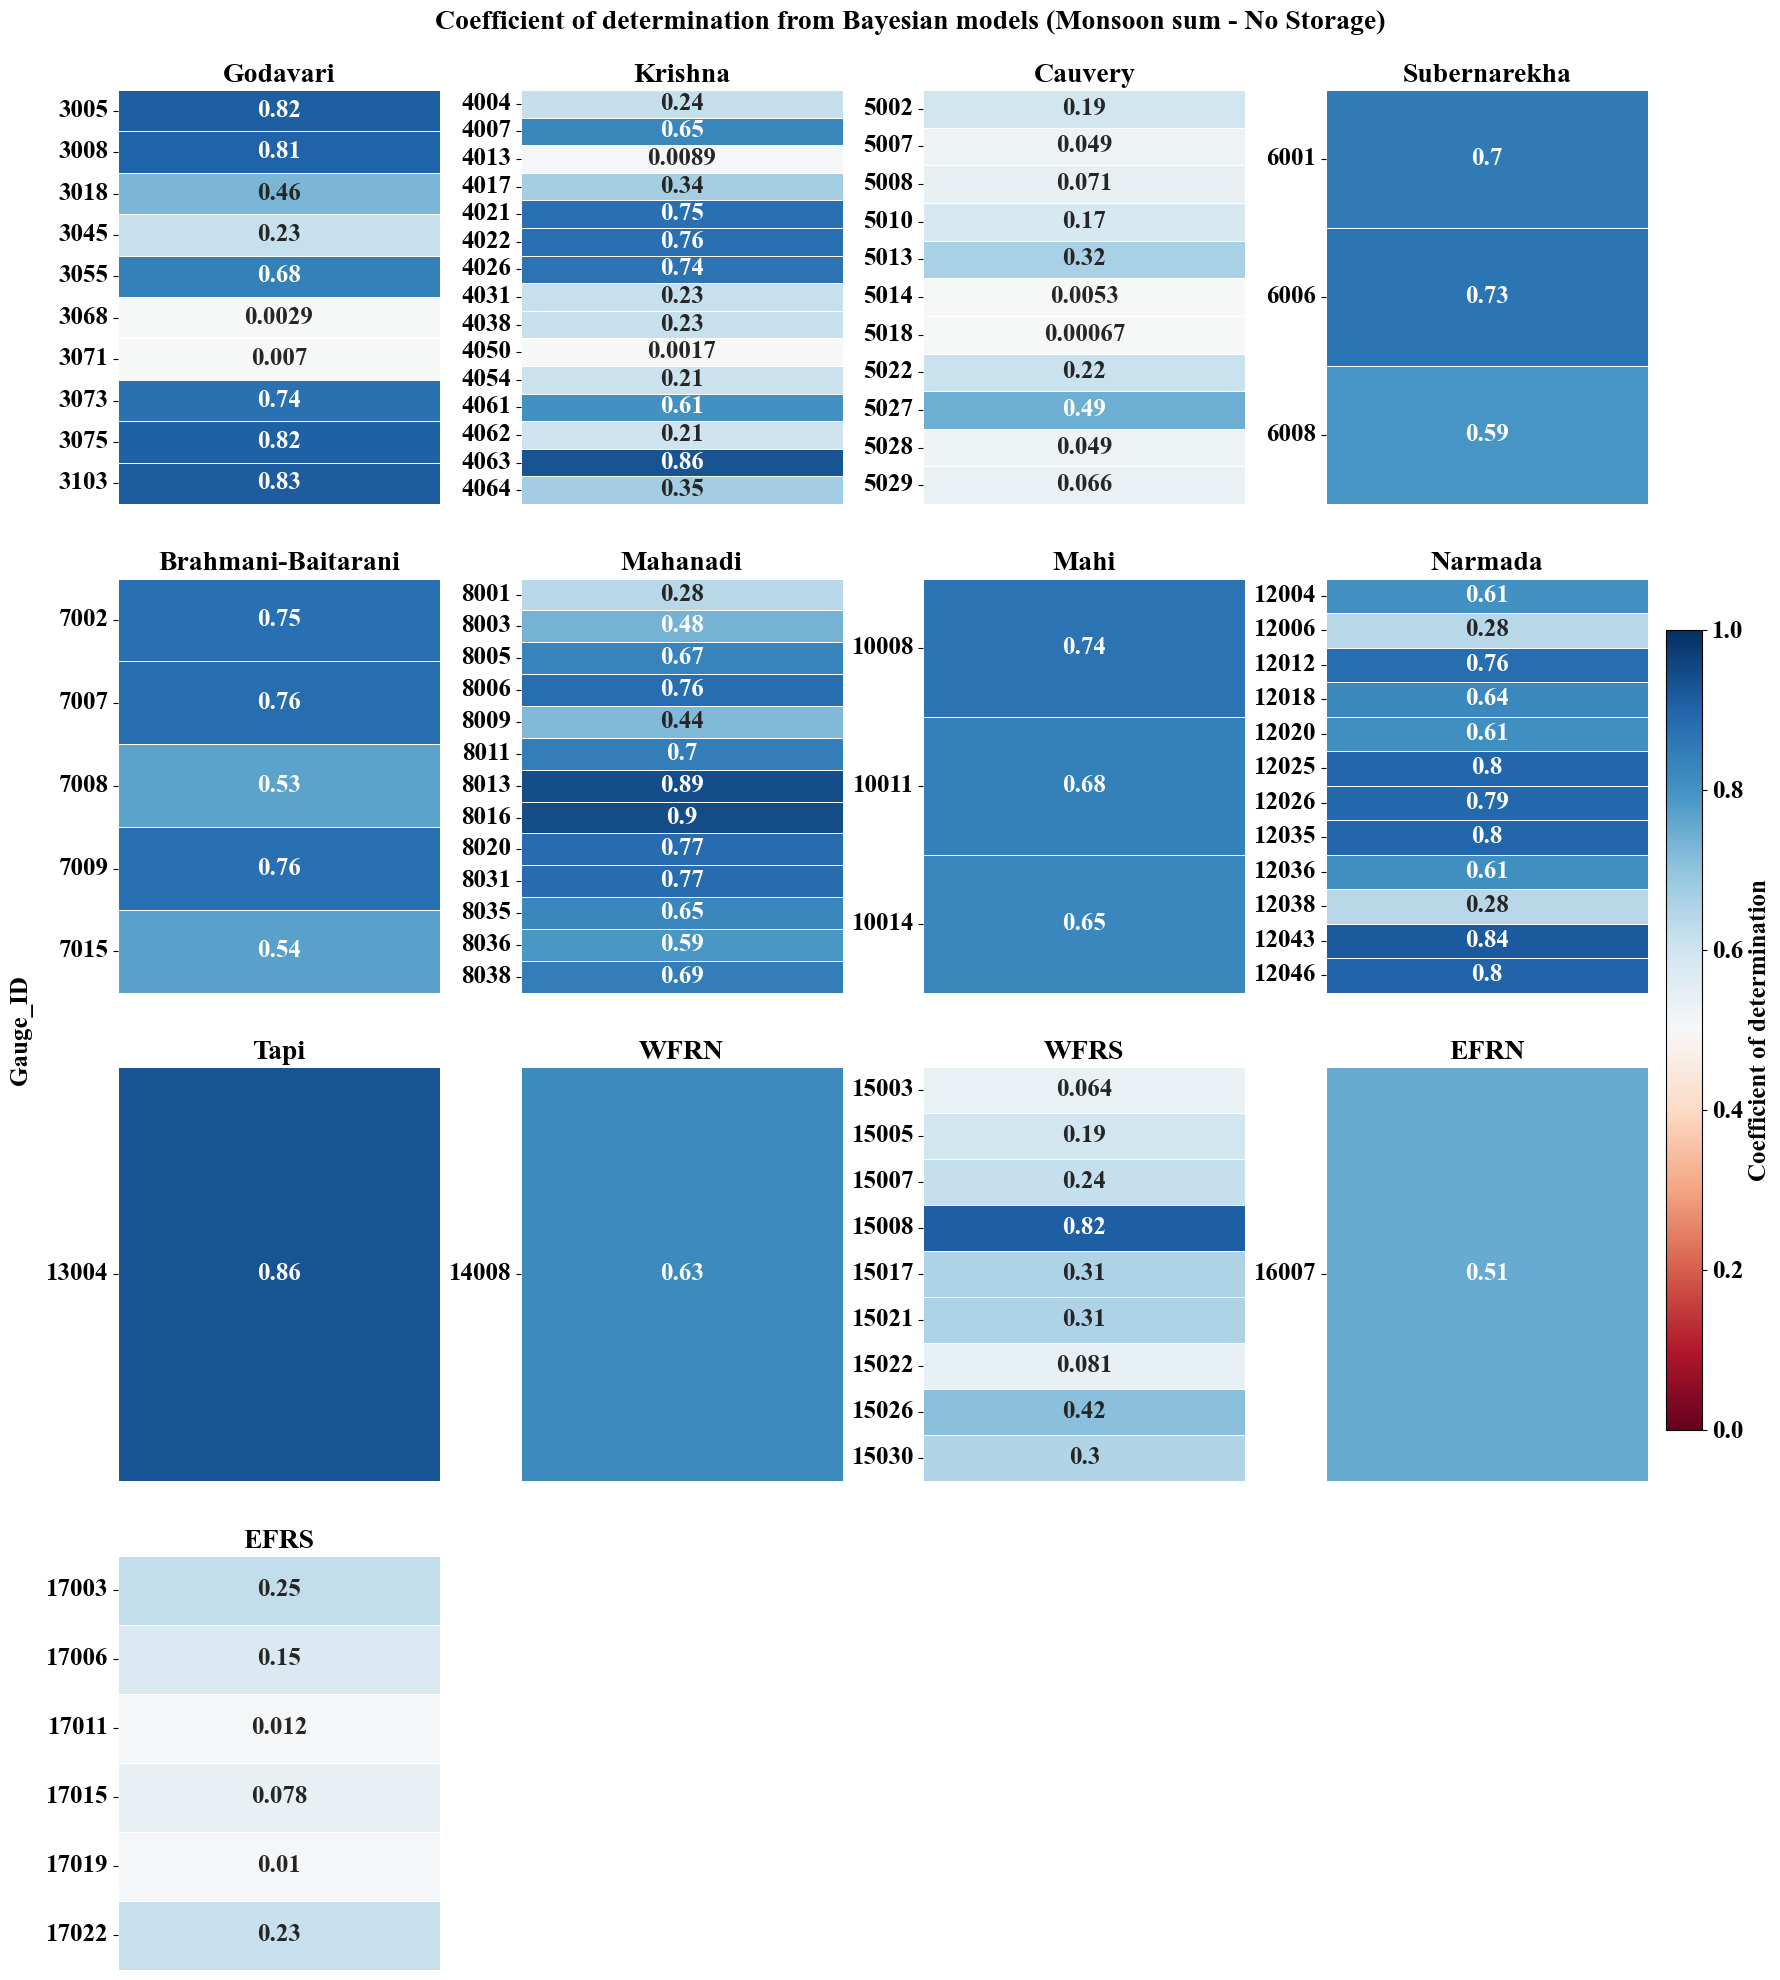

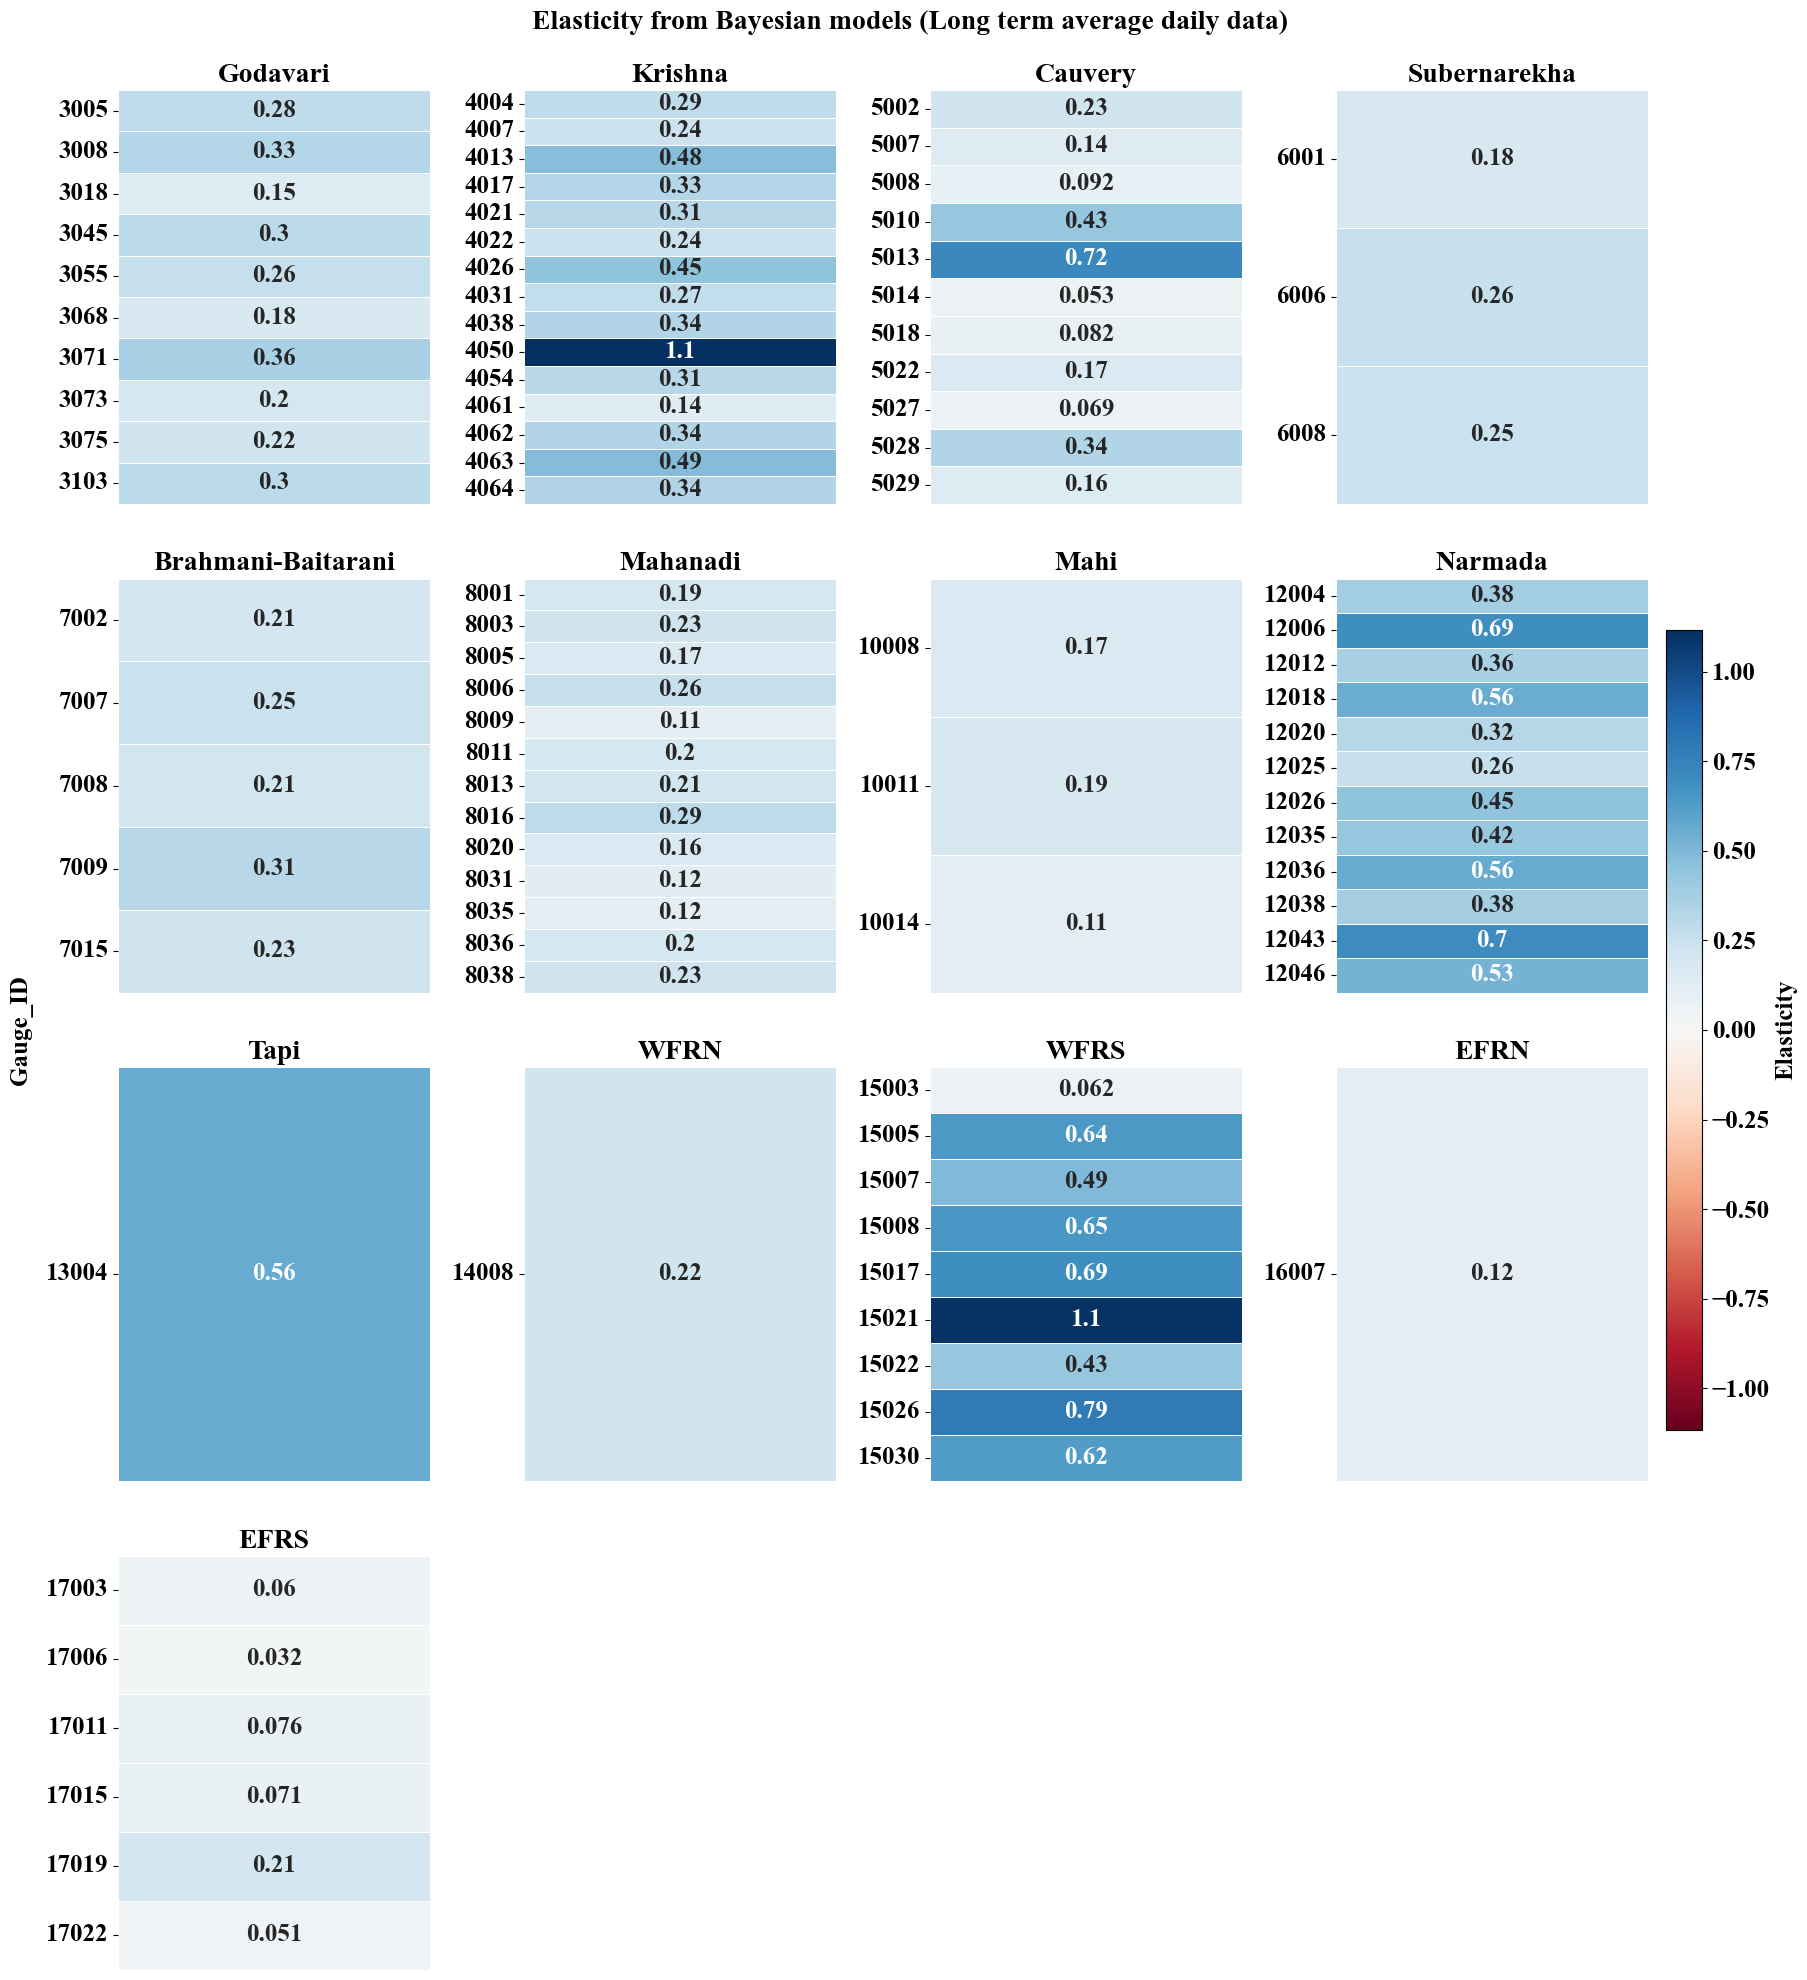

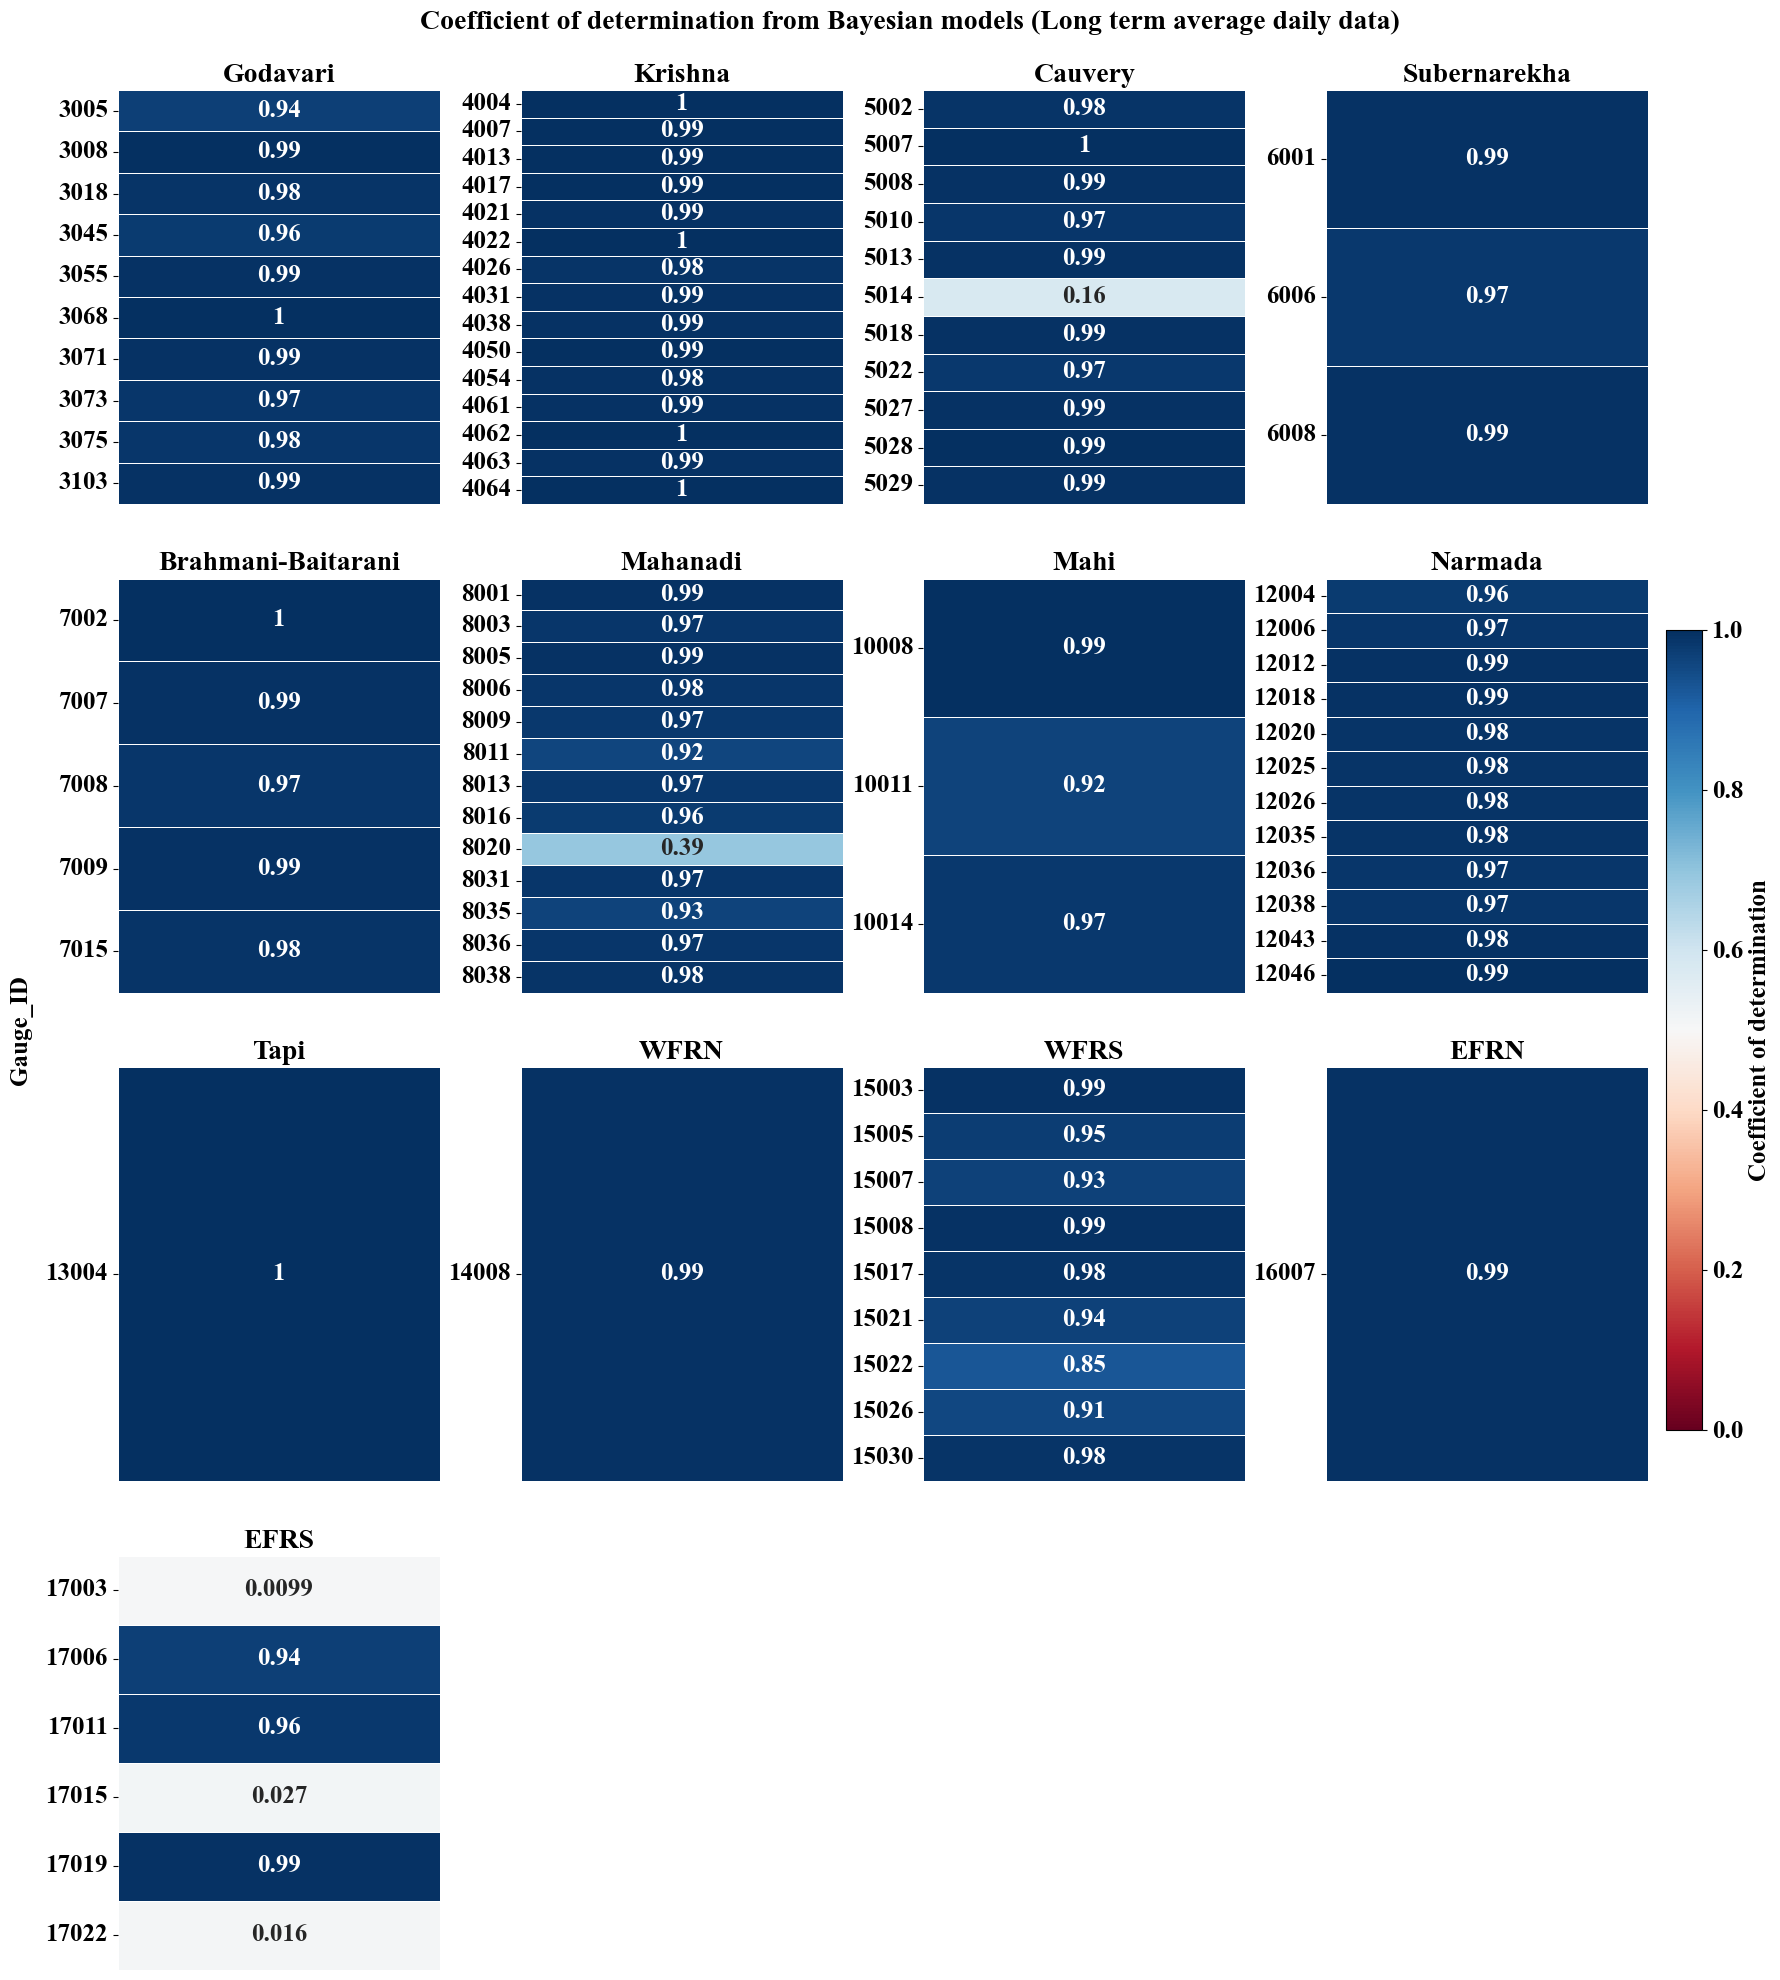

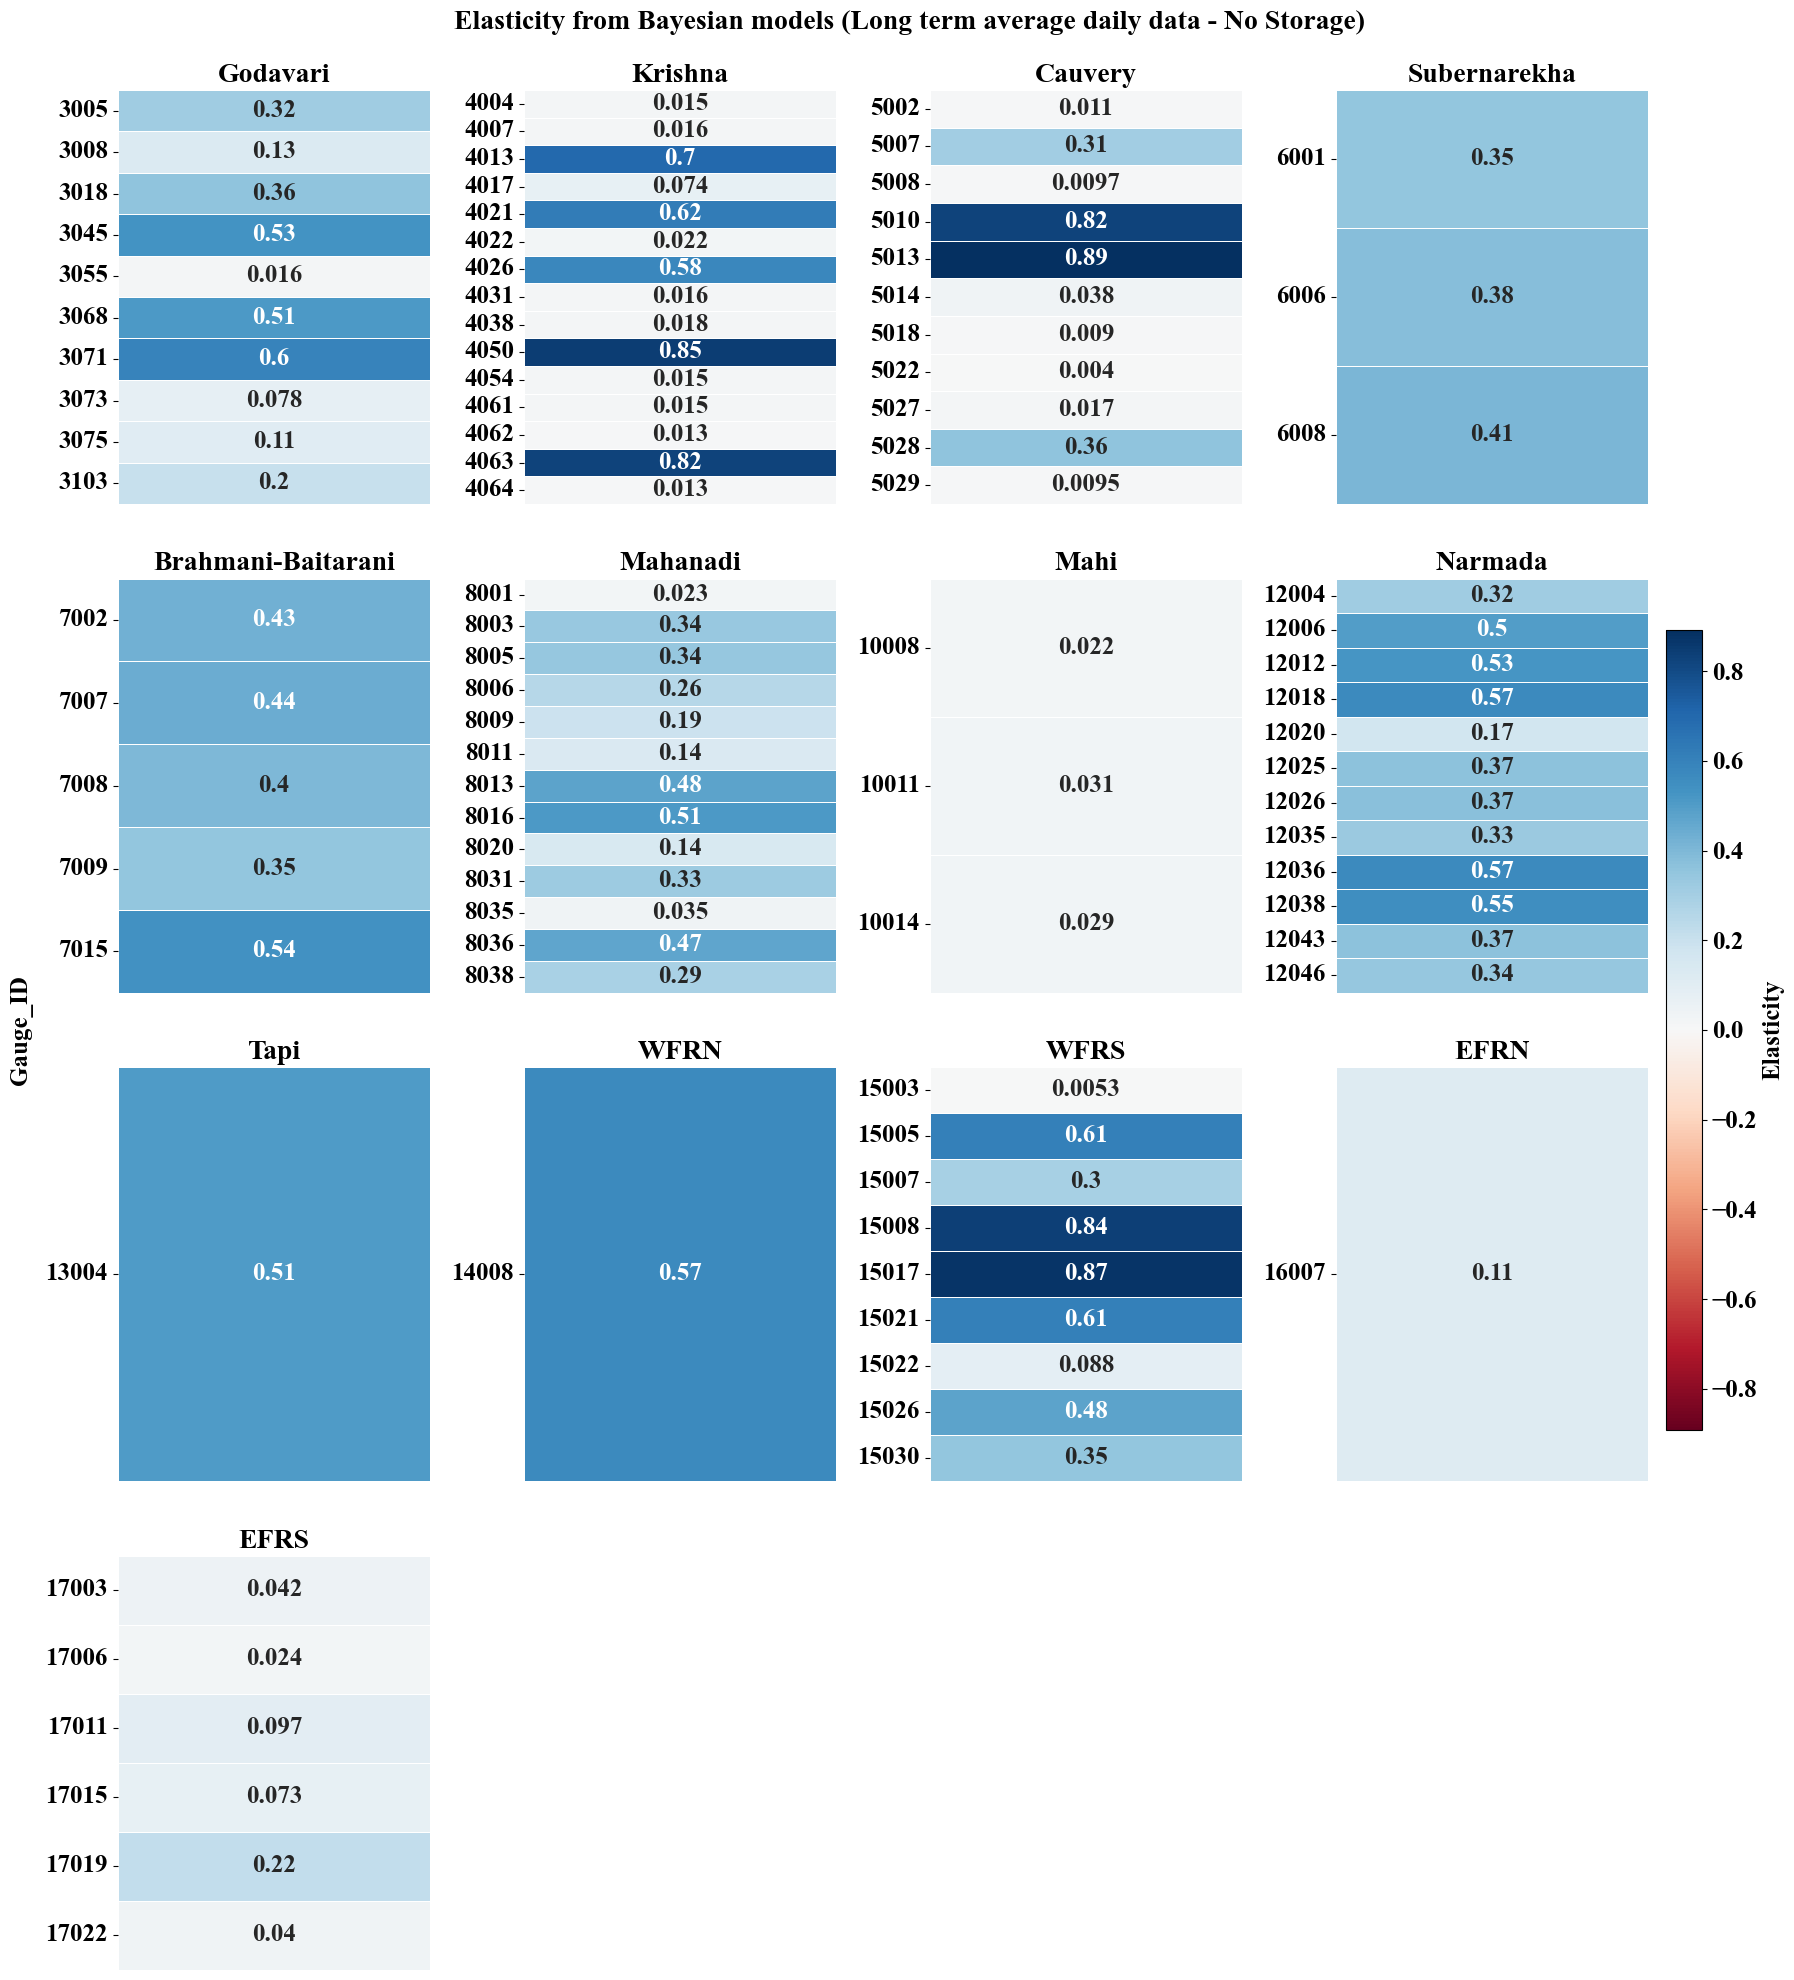

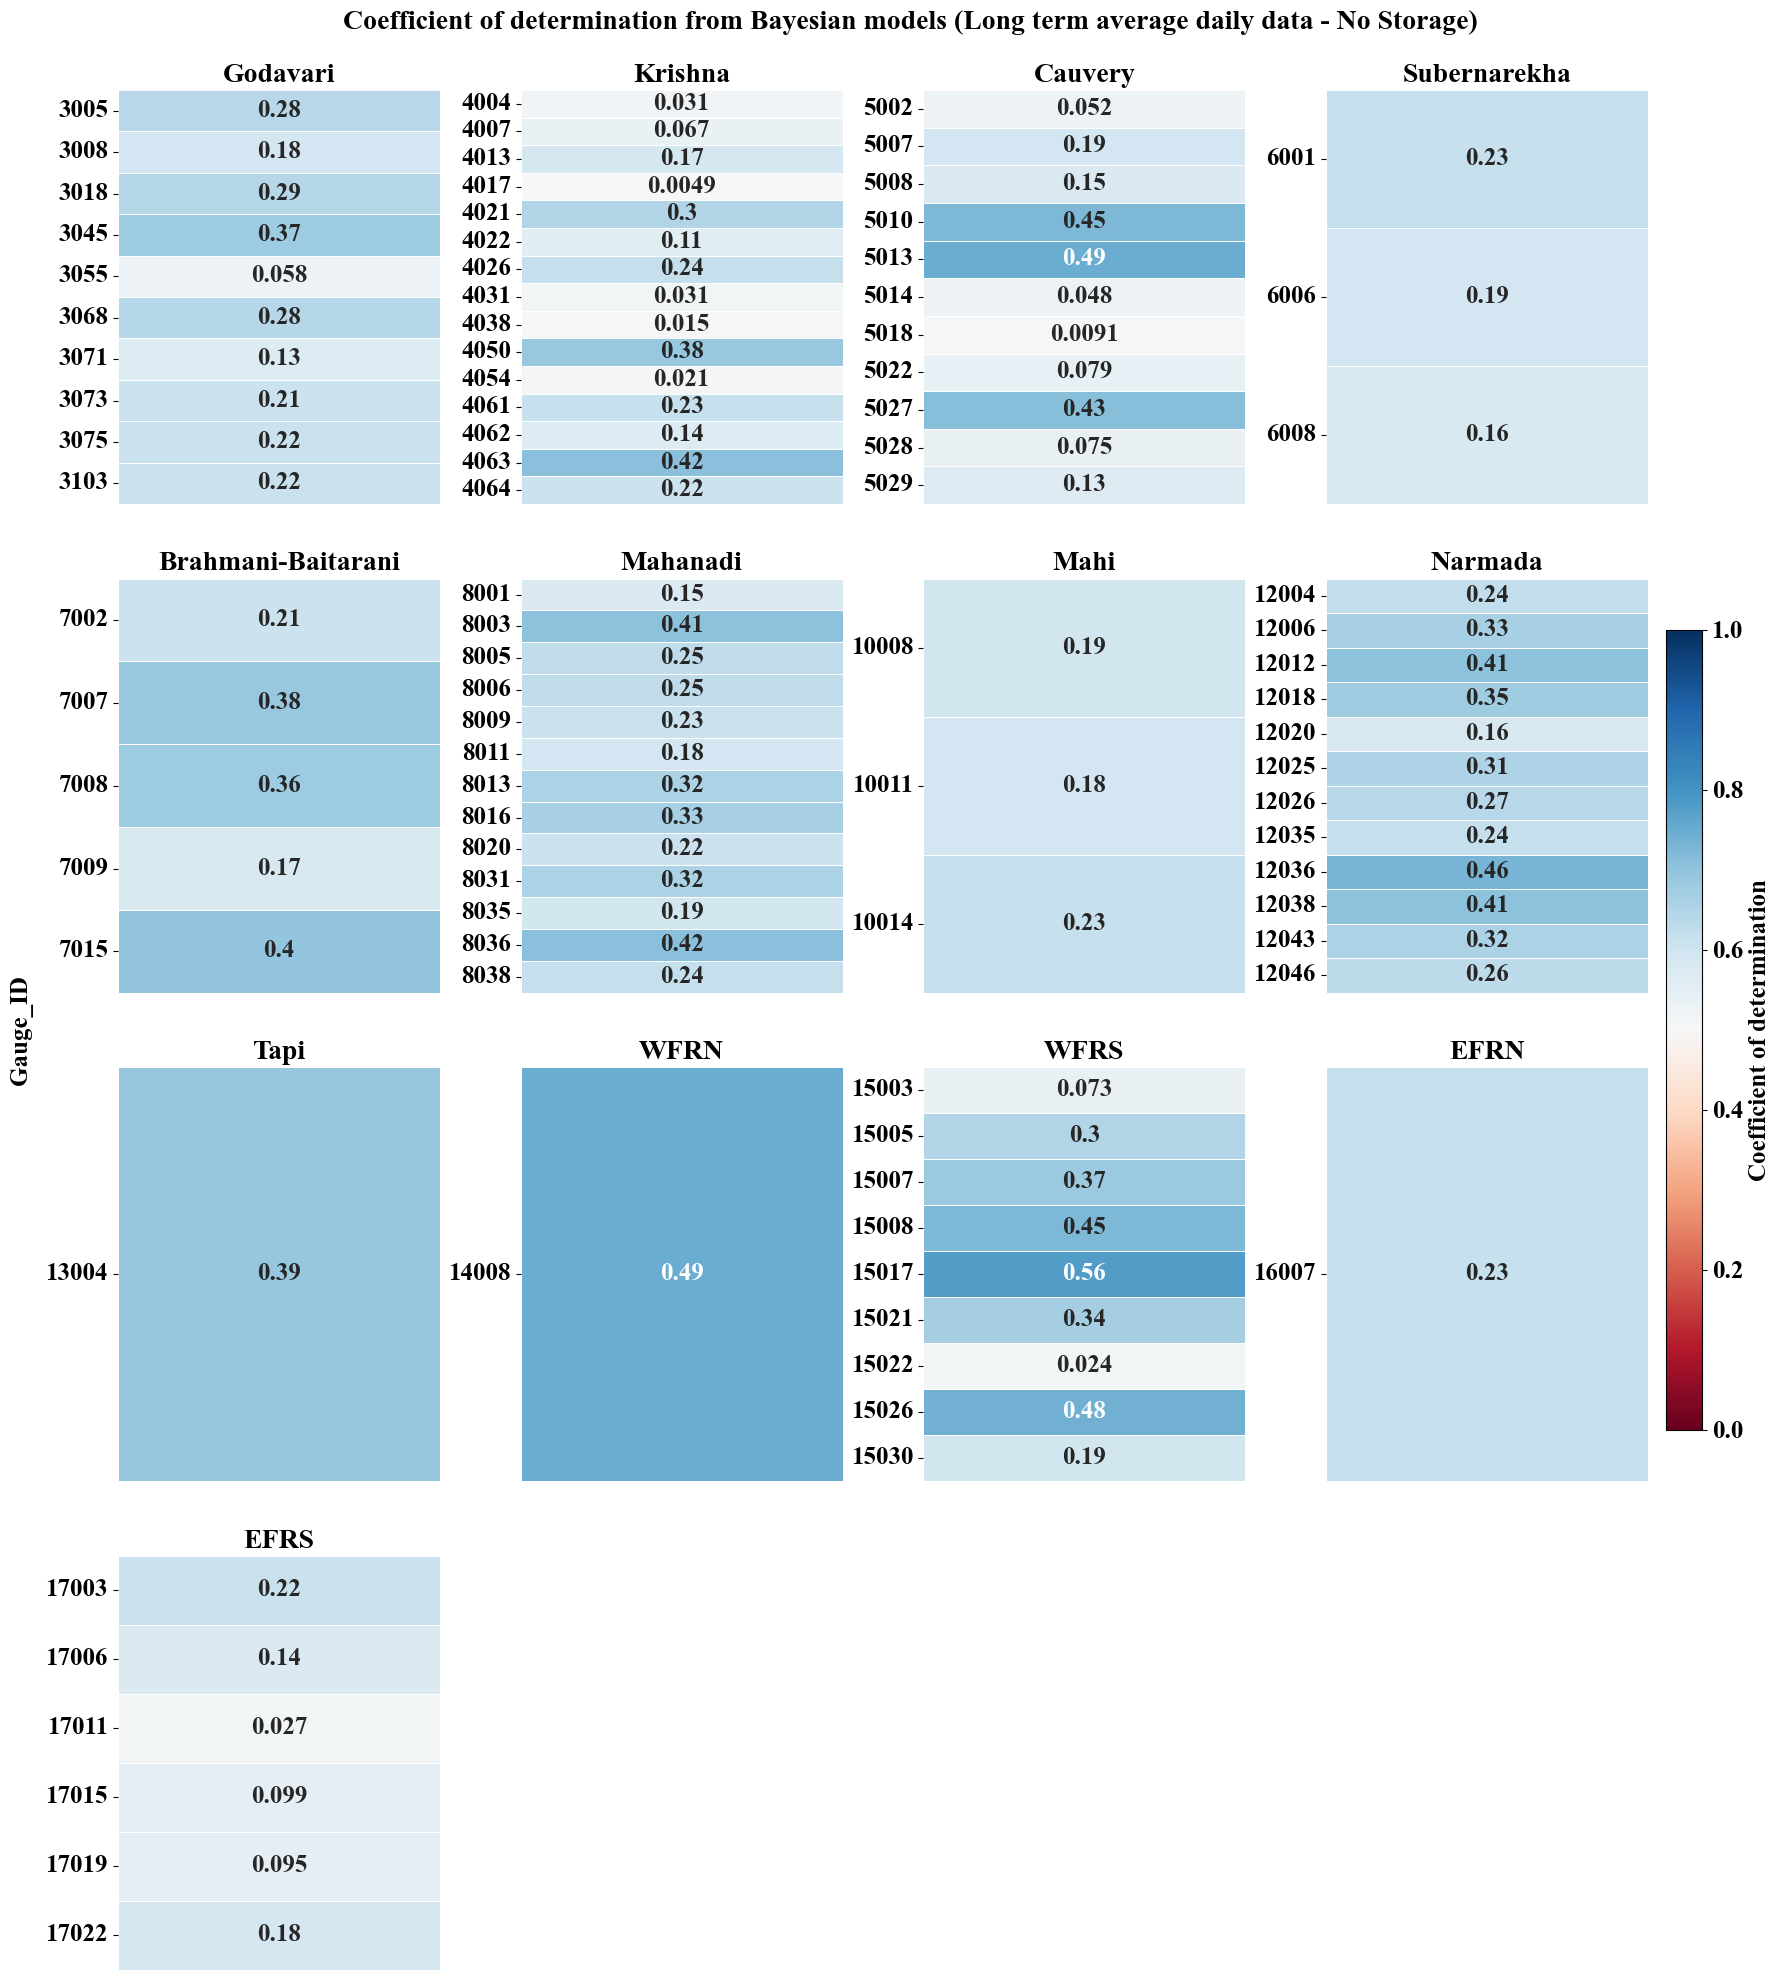

In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm

# ------------------------
# GLOBAL FONT SETTINGS
# ------------------------
mpl.rcParams['font.family'] = 'Times New Roman'

# ------------------------
# BASIN ORDER
# ------------------------
basins = [
    "Godavari", "Krishna", "Cauvery", "Subernarekha",
    "Brahmani-Baitarani", "Mahanadi", "Mahi", "Narmada",
    "Tapi", "WFRN", "WFRS", "EFRN", "EFRS"
]

# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
plot_dir = os.path.join(data_dir, "pics_bayes")
os.makedirs(plot_dir, exist_ok=True)

summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="Sheet1")

# ------------------------
# FILES AND NAMES
# ------------------------
files = [
    "ElasticityBM_AnnualSum.xlsx",
    "ElasticityBM_AnnualSum_NoStorage.xlsx",
    "ElasticityBM_Monsoon.xlsx",
    "ElasticityBM_MonsoonSum_NoStorage.xlsx",
    "ElasticityBM_LongTermMean.xlsx",
    "ElasticityBM_LongTermMean_NoStorage.xlsx"
]

names = [
    "Annual sum",
    "Annual sum - No Storage",
    "Monsoon sum",
    "Monsoon sum - No Storage",
    "Long term average daily data",
    "Long term average daily data - No Storage"
]

# ------------------------
# LOOP THROUGH FILES
# ------------------------
for f, label_name in zip(files, names):
    elasticity_df = pd.read_excel(os.path.join(trace_dir, f), sheet_name="Sheet1")
    merged_df = pd.merge(summary_df, elasticity_df, left_on="Gauge_ID", right_on="gauge_id", how="inner")
    merged_df.rename(columns={"Elasticity": "Elasticity_epsilon"}, inplace=True)

    merged_df["Basin"] = pd.Categorical(merged_df["Basin"], categories=basins, ordered=True)
    merged_df = merged_df.sort_values(by=["Basin", "Gauge_ID"])

    plot_basins = [b for b in basins if b in merged_df["Basin"].unique()]
    n_basins = len(plot_basins)
    max_cols = 4
    n_cols = min(n_basins, max_cols)
    n_rows = math.ceil(n_basins / n_cols)

    # =====================================================
    # 1. Elasticity heatmap per basin
    # =====================================================
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    abs_max = abs(merged_df["Elasticity_epsilon"]).max()
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])

    for i, basin in enumerate(plot_basins):
        ax = axes[i]
        basin_df = merged_df[merged_df["Basin"] == basin].sort_values("Gauge_ID")
        heat_df = pd.DataFrame(
            {"Elasticity ε": basin_df["Elasticity_epsilon"].values},
            index=basin_df["Gauge_ID"].astype(str)
        )

        sns.heatmap(
            heat_df, ax=ax, cmap="RdBu", norm=norm,
            annot=True, annot_kws={"weight": "bold", "fontsize": 18},
            linewidths=0.5, linecolor="white",
            cbar=(i == 0), cbar_ax=cbar_ax if i == 0 else None
        )

        ax.set_title(basin, fontsize=20, fontweight="bold")
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])                     # remove x-tick labels
        ax.tick_params(axis='x', bottom=False)     # remove x-tick marks
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18, fontweight="bold")

    for j in range(n_basins, len(axes)):
        fig.delaxes(axes[j])

    fig.text(0, 0.5, "Gauge_ID", va="center", rotation="vertical",
             fontsize=18, fontweight="bold")

    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="RdBu"), cax=cbar_ax)
    cbar.set_label("Elasticity", fontsize=18, fontweight='bold')
    cbar_ax.yaxis.set_tick_params(labelsize=18)
    for label in cbar_ax.yaxis.get_ticklabels():
        label.set_fontweight("bold")

    fig.suptitle(f"Elasticity from Bayesian models ({label_name})",
                 fontsize=20, fontweight="bold", x=0.5, y=1.01)
    plt.subplots_adjust(left=0.06, right=0.91, top=0.97,
                        bottom=0.03, hspace=0.18, wspace=0.3)
    plt.savefig(os.path.join(plot_dir, f"1_1_elasticity_{label_name.replace(' ', '_')}.png"),
                dpi=300, bbox_inches="tight")
    plt.show()

    # =====================================================
    # 2. R² heatmap per basin
    # =====================================================
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])

    for i, basin in enumerate(plot_basins):
        ax = axes[i]
        basin_df = merged_df[merged_df["Basin"] == basin].sort_values("Gauge_ID")
        heat_df = pd.DataFrame(
            {"R²": basin_df["R2"].values},
            index=basin_df["Gauge_ID"].astype(str)
        )

        sns.heatmap(
            heat_df, ax=ax, cmap="RdBu", vmin=-1, vmax=1,
            annot=True, annot_kws={"weight": "bold", "fontsize": 18},
            linewidths=0.5, linecolor="white",
            cbar=(i == 0), cbar_ax=cbar_ax if i == 0 else None
        )

        ax.set_title(basin, fontsize=20, fontweight="bold")
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])                     # remove x-tick labels
        ax.tick_params(axis='x', bottom=False)     # remove x-tick marks
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18, fontweight="bold")

    for j in range(n_basins, len(axes)):
        fig.delaxes(axes[j])

    fig.text(0, 0.5, "Gauge_ID", va="center", rotation="vertical",
             fontsize=18, fontweight="bold")

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdBu"), cax=cbar_ax)
    cbar.set_label("Coefficient of determination", fontsize=18, fontweight='bold')
    cbar_ax.yaxis.set_tick_params(labelsize=18)
    for label in cbar_ax.yaxis.get_ticklabels():
        label.set_fontweight("bold")

    fig.suptitle(f"Coefficient of determination from Bayesian models ({label_name})",
                 fontsize=20, fontweight="bold", x=0.5, y=1.01)
    plt.subplots_adjust(left=0.06, right=0.91, top=0.97,
                        bottom=0.03, hspace=0.18, wspace=0.25)
    plt.savefig(os.path.join(plot_dir, f"1_2_R2_{label_name.replace(' ', '_')}.png"),
                dpi=300, bbox_inches="tight")
    plt.show()


In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from scipy.stats import gaussian_kde
import pandas as pd
from matplotlib.lines import Line2D
# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\PPOSA\OneDrive - The University of Melbourne\1 Poornima_Research_Work\6 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
plot_dir = os.path.join(data_dir, "pics_bayes")
os.makedirs(plot_dir, exist_ok=True)

# Load basin-gauge mapping
summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="Sheet1")
summary_df["Gauge_ID"] = summary_df["Gauge_ID"].astype(str)

# Count number of stations per basin
basin_station_counts = summary_df.groupby("Basin")["Gauge_ID"].nunique()

print("Number of stations per basin:")
print(basin_station_counts)

Number of stations per basin:
Basin
Brahmani-Baitarani     5
Cauvery               11
EFRN                   1
EFRS                   6
Godavari              10
Krishna               15
Mahanadi              13
Mahi                   3
Narmada               12
Subernarekha           3
Tapi                   1
WFRN                   1
WFRS                   9
Name: Gauge_ID, dtype: int64


In [ ]:
###################     prior and posterior of k (epsilon)

In [66]:
print(list(tr["posterior"].keys()))       # parameters you sampled
print(list(tr["observed_data"].keys()))   # observed data variables
      # site metadata
['beta_S', 'W', 'alpha', 'k', 'sigma_Q', 'log_Q_nat', 'mu_log_Q_obs', 'Q_pred']
['log_Q_observed']
['Gauge_id']

['beta_S', 'W', 'alpha', 'k', 'sigma_Q', 'log_Q_nat', 'mu_log_Q_obs', 'Q_pred']
['log_Q_observed']
['log_Q_observed']


['Gauge_id']